In [ ]:
pip install geopandas ibge unidecode pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from ibge.localidades import *
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from pathlib import Path
import unidecode

In [ ]:
pip install chardet

In [ ]:
import chardet

file_path = '/content/drive/MyDrive/Material_mestrado/Séries Temporais/data/tuberculose/TUBEBR04.csv'

# Detecta a codificação
with open(file_path, 'rb') as f:
    raw_data = f.read(10000)  # Lê os primeiros 10000 bytes do arquivo
    result = chardet.detect(raw_data)
    print(f"Codificação detectada: {result['encoding']}")

Codificação detectada: ascii


In [ ]:
#Carregamento do dados utilizados:
data = []
path_csv = '/content/drive/MyDrive/Material_mestrado/Séries Temporais/data/tuberculose'

for file in os.listdir(path_csv):
  if file.lower().endswith(".csv"):
    file_path = os.path.join(path_csv, file)
    try:
              # Tentar carregar como CSV
              df = pd.read_csv(file_path, encoding='latin1', low_memory=False)
              data.append(df)
    except:
            print(f"Falha ao carregar o arquivo: {file}")

#faz a combinação de todos os arquivos em um único dataframe
if data:
    end_df = pd.concat(data, ignore_index=True)
else:
    print("Nenhum arquivo CSV encontrado.")

dados_est = pd.DataFrame(end_df)
dados_est.head()


TP_NOT  TP_NOT.1 ID_AGRAVO  DT_NOTIFIC  NU_ANO  SG_UF_NOT  ID_MUNICIP  \
0      2       2.0         0    20010104    2001         41    410420.0   
1      2       2.0         0    20010220    2001         41    410690.0   
2      2       2.0         0    20010112    2001         26    260570.0   
3      2       2.0         0    20010223    2001         15    150140.0   
4      2       2.0         0    20010105    2001         13    130120.0   

   ID_REGIONA   DT_DIAG  ANO_NASC  ...  BENEF_GOV AGRAVDROGA  AGRAVTABAC  \
0      1356.0  20010104    1961.0  ...        0.0        0.0         0.0   
1      1356.0  20010220    1974.0  ...        0.0        0.0         0.0   
2      1506.0  20010112    1960.0  ...        0.0        0.0         0.0   
3      1484.0  20010223    1975.0  ...        0.0        0.0         0.0   
4         0.0  20010105    1975.0  ...        0.0        0.0         0.0   

   TEST_MOLEC  TEST_SENSI  ANT_RETRO  BAC_APOS_6  TRANSF  UF_TRANSF  \
0         0.0         0.0        0.0         0.0     0.0        0.0   
1         0.0         0.0        0.0         0.0     0.0        0.0   
2         0.0         0.0        0.0         0.0     0.0        0.0   
3         0.0         0.0        0.0         0.0     0.0        0.0   
4         0.0         0.0        0.0         0.0     0.0        0.0   

   MUN_TRANSF  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 98 columns]

In [ ]:
end_df = end_df[end_df['NU_ANO'] >= 2000]

In [ ]:
#Elimina as linhas totais do dataframe utilizado:
df_dados = end_df [end_df['TP_NOT'] != 'Total']

In [ ]:
#Busca por colunas com valores ausentes:

missing_values = df_dados.isnull().sum()

if missing_values.sum() == 0:
    print("Nenhum valor ausente encontrado.")
    print("Análise individual por coluna:")
    for col in end_df.columns:
      print(f"Coluna {col}: {end_df[col].astype(str).str.strip().eq('').sum()} valores vazios")

else:

    # Calcular a porcentagem de valores ausentes
    missing_percentage = (missing_values / len(df_dados)) * 100

    # Criar um DataFrame organizado por maior percentual de valores ausentes
    missing_data = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
    missing_data = missing_data[missing_data["Missing Values"] > 0].sort_values(by="Percentage", ascending=False)

    # Exibir as colunas com valores ausentes
    print(missing_data)



            Missing Values  Percentage
TP_NOT.1            502533   24.025203
CS_FLXRET           502533   24.025203
ID_OCUPA_N          502533   24.025203
MIGRADO_W           502533   24.025203
FLXRECEBI           502533   24.025203
...                    ...         ...
FORMA                  126    0.006024
NU_IDADE_N             118    0.005641
BACILOSC_E             117    0.005594
CULTURA_ES             117    0.005594
ID_MUNICIP               1    0.000048

[76 rows x 2 columns]


In [ ]:
# Substituir os dados faltantes nas colunas numéricas pela mediana
# Selecionar apenas colunas numéricas com dtype numérico
numeric_columns = df_dados.select_dtypes(include=np.number).columns

# Preencher valores ausentes apenas nas colunas numéricas com dtype numérico
df_dados.loc[:, numeric_columns] = df_dados[numeric_columns].fillna(df_dados[numeric_columns].median())

# Substituir os dados faltantes nas colunas não numéricas pela moda
# Selecionar colunas não numéricas
non_numeric_columns = df_dados.select_dtypes(exclude=np.number).columns

# Preencher valores ausentes nas colunas não numéricas com a moda
for col in non_numeric_columns:
  df_dados.loc[:, col] = df_dados[col].fillna(df_dados[col].mode()[0])


In [ ]:
#Busca por colunas com valores ausentes:

missing_values = df_dados.isnull().sum()

if missing_values.sum() == 0:
    print("Nenhum valor ausente encontrado.")





Nenhum valor ausente encontrado.


In [ ]:
# Verificar colunas com valor constante e seus valores
colunas_constantes = {col: df_dados[col].iloc[0] for col in df_dados.columns if df_dados[col].nunique() == 1}

if colunas_constantes:
    print("Colunas com valor constante e seus respectivos valores:")
    for coluna, valor in colunas_constantes.items():
        print(f"{coluna}: {valor}")
else:
    print("Não há colunas com valores constantes no DataFrame.")

# Retirar  as colunas com valor constante
df_dados = df_dados.drop(columns=colunas_constantes)

print(f"Colunas removidas: {colunas_constantes}")
print(f"DataFrame atualizado com {df_dados.shape[1]} colunas.")


Colunas com valor constante e seus respectivos valores:
TP_NOT.1: 2.0
CS_FLXRET: 0.0
FLXRECEBI: 0.0
Colunas removidas: {'TP_NOT.1': 2.0, 'CS_FLXRET': 0.0, 'FLXRECEBI': 0.0}
DataFrame atualizado com 95 colunas.


In [ ]:
# Filtrar o DataFrame excluindo as linhas com NDUPLIC_N == 2
df_dados = df_dados[df_dados["NDUPLIC_N"] != 2]

print("Linhas com NDUPLIC_N == 2 foram removidas.")
print(f"DataFrame atualizado com {df_dados.shape[0]} linhas.")

Linhas com NDUPLIC_N == 2 foram removidas.
DataFrame atualizado com 2091641 linhas.


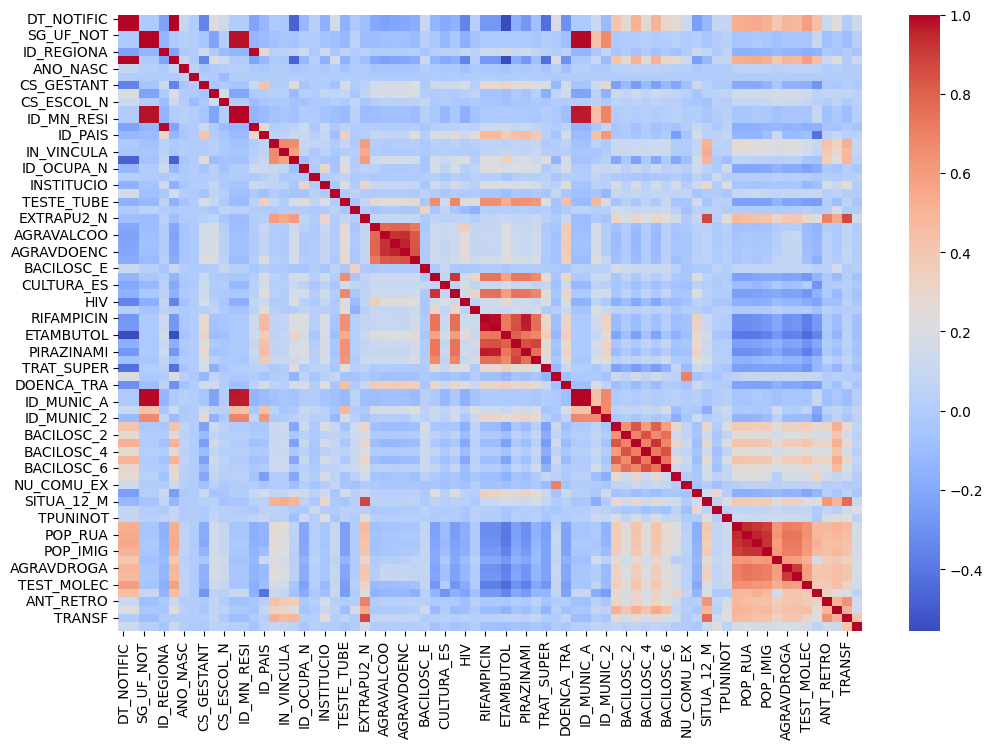

In [ ]:
#Analisando a correlação entre as variaveis em um momento inicial:

# Calcular a matriz de correlação
corr_matrix = df_dados.corr(numeric_only=True)

# Plotar um heatmap de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title(f"Tuberculosis original data correlation matrix", fontsize=16)
plt.show()

In [ ]:
import numpy as np

# Calcular a matriz de correlação
correlation_matrix = df_dados.corr(numeric_only= True).abs()

# Selecionar as colunas altamente correlacionadas
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encontrar pares de colunas com correlação maior que 0.85
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]

print("Colunas encontradas para remoção:", highly_correlated_features)

Colunas encontradas para remoção: ['NU_ANO', 'ID_MUNICIP', 'DT_DIAG', 'SG_UF', 'ID_MN_RESI', 'ID_RG_RESI', 'AGRAVDIABE', 'AGRAVDOENC', 'CULTURA_OU', 'ISONIAZIDA', 'ESTREPTOMI', 'PIRAZINAMI', 'OUTRAS', 'SG_UF_AT', 'ID_MUNIC_A', 'BACILOSC_5', 'SITUA_12_M', 'POP_RUA', 'POP_SAUDE', 'POP_IMIG', 'AGRAVTABAC', 'TRANSF']


In [ ]:
colunas_eliminadas = {

    "NDUPLIC_N", "ID_UNIDADECS_GESTANT", "SEM_DIAG", "SG_UF",
    "CS_ESCOL_N", "ID_MN_RESI", "ID_RG_RESI", "ID_PAIS",
    "NDUPLIC_N", "DT_DIGITA", "DT_TRANSUS", "DT_TRANSDM",
    "DT_TRANSSM", "DT_TRANSRS", "DT_TRANSSE", "NU_LOTE_V",
    "NU_LOTE_H", "MIGRADO_W", "ID_OCUPA_N", "IN_VINCULA",
    "NU_LOTE_IA", "ID_MUNICIP", "DT_DIAG", "EXTRAPU2",
     "AGRAVDOENC", "AGRAVOUTRA", "CULTURA_OU",
    "ISONIAZIDA", "ESTREPTOMI", "PIRAZINAMI", "ETIONAMIDA",
    "OUTRAS", "OUTRAS_DES", "SG_UF_AT", "ID_MUNIC_A",
    "BACILOSC_5", "SITUA_12_M",
    "POP_IMIG", "AGRAVTABAC", "BACILOSC_1",
    "BACILOSC_2","BACILOSC_3", "BACILOSC_4",
    "BACILOSC_5", "BACILOSC_6","RIFAMPICIN", "MUN_TRANSF",
    "TEST_MOLEC", "TEST_SENSI", "ANT_RETRO", "BAC_APOS_6",
    "BENEF_GOV", "ETAMBUTOL","POP_LIBER",
    "AGRAVALCOO", "TESTE_TUBE", "BACILOSC_O",
    "TRAT_SUPER", "DT_MUDANCA",


                    }

# Eliminar as colunas especificadas
df_dados = df_dados.drop(columns=colunas_eliminadas, errors='ignore')

print(f"As colunas {colunas_eliminadas} foram removidas.")
print(f"O DataFrame agora tem {df_dados.shape[1]} colunas.")

As colunas {'AGRAVOUTRA', 'RIFAMPICIN', 'ETIONAMIDA', 'DT_TRANSSM', 'BACILOSC_4', 'DT_TRANSRS', 'NDUPLIC_N', 'ISONIAZIDA', 'ETAMBUTOL', 'OUTRAS', 'NU_LOTE_H', 'BACILOSC_1', 'BACILOSC_3', 'TEST_MOLEC', 'MIGRADO_W', 'IN_VINCULA', 'CS_ESCOL_N', 'ID_MN_RESI', 'TESTE_TUBE', 'TEST_SENSI', 'BACILOSC_6', 'EXTRAPU2', 'BACILOSC_5', 'BACILOSC_O', 'DT_TRANSSE', 'PIRAZINAMI', 'ANT_RETRO', 'DT_DIAG', 'ID_RG_RESI', 'SEM_DIAG', 'CULTURA_OU', 'AGRAVTABAC', 'NU_LOTE_V', 'POP_LIBER', 'BENEF_GOV', 'DT_TRANSUS', 'SG_UF', 'BAC_APOS_6', 'NU_LOTE_IA', 'TRAT_SUPER', 'ID_OCUPA_N', 'ID_PAIS', 'AGRAVDOENC', 'ID_MUNIC_A', 'DT_MUDANCA', 'SG_UF_AT', 'BACILOSC_2', 'DT_TRANSDM', 'OUTRAS_DES', 'AGRAVALCOO', 'POP_IMIG', 'ESTREPTOMI', 'ID_MUNICIP', 'SITUA_12_M', 'DT_DIGITA', 'MUN_TRANSF', 'ID_UNIDADECS_GESTANT'} foram removidas.
O DataFrame agora tem 44 colunas.


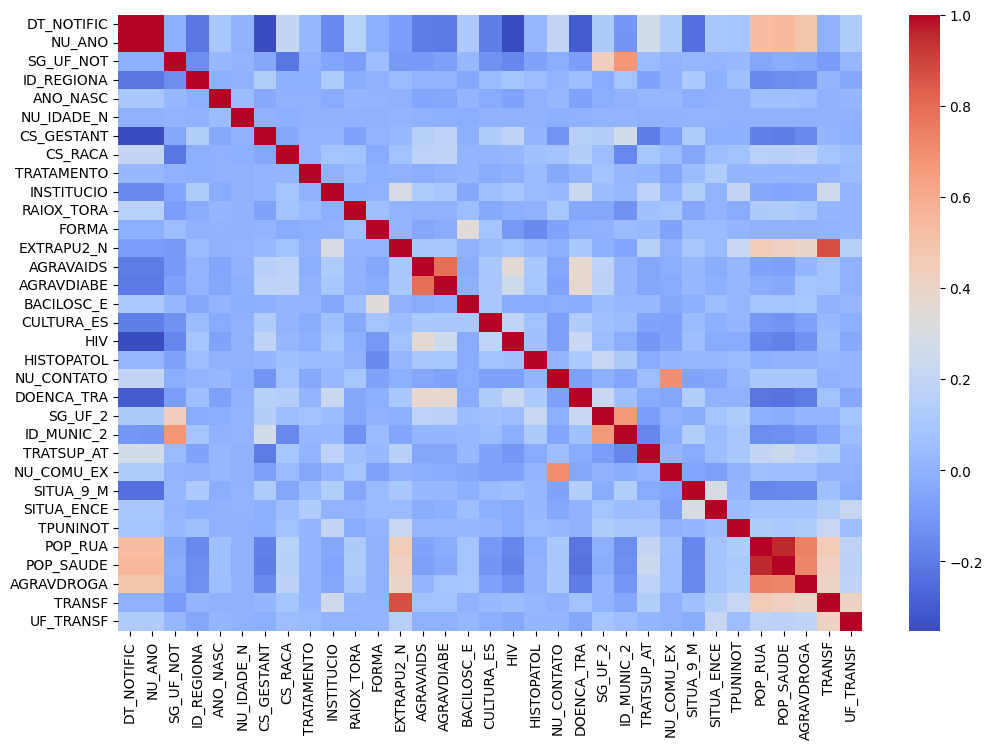

In [ ]:
#Analisando a correlação entre as variaveis após a seleção das colunas:

# Calcular a matriz de correlação
corr_matrix = df_dados.corr(numeric_only= True)

# Plotar um heatmap de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title(f"Correlation matrix after column selection Tuberculosis", fontsize=16)

plt.show()

In [ ]:
#Carrega as informações do estados da biblioteca do IBGE
dados_estados = Estados()
if isinstance(dados_estados.json_ibge, (list, dict)):
    dt_est = dados_estados.json_ibge
    print(dt_est)
else:
    dt_est = json.loads(dados_estados.json_ibge)
    print(dt_est)
dt_est[0]

dados_est = []
for dado in dt_est:
    linha = {
        "id": dado["id"],
        "sigla": dado["sigla"],
        "nome": dado["nome"],
        "regiao": dado["regiao"]["nome"]  # Acessa o nome da região corretamente
    }
    dados_est.append(linha)

regioes_brasil = {
    "Norte": "North",
    "Nordeste": "Northeast",
    "Centro-Oeste": "Central-West",
    "Sudeste": "Southeast",
    "Sul": "South"
}

# Criar DataFrame com as informações de estados e regiões
df_estados = pd.DataFrame(dados_est)
#print(df_estados.head())

[{'id': 11, 'sigla': 'RO', 'nome': 'Rondônia', 'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}, {'id': 12, 'sigla': 'AC', 'nome': 'Acre', 'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}, {'id': 13, 'sigla': 'AM', 'nome': 'Amazonas', 'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}, {'id': 14, 'sigla': 'RR', 'nome': 'Roraima', 'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}, {'id': 15, 'sigla': 'PA', 'nome': 'Pará', 'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}, {'id': 16, 'sigla': 'AP', 'nome': 'Amapá', 'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}, {'id': 17, 'sigla': 'TO', 'nome': 'Tocantins', 'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}, {'id': 21, 'sigla': 'MA', 'nome': 'Maranhão', 'regiao': {'id': 2, 'sigla': 'NE', 'nome': 'Nordeste'}}, {'id': 22, 'sigla': 'PI', 'nome': 'Piauí', 'regiao': {'id': 2, 'sigla': 'NE', 'nome': 'Nordeste'}}, {'id': 23, 'sigla': 'CE', 'nome': 'Ceará', 'regiao': {'id': 2, 'sigla': 'NE', 'nome': 'Nordeste'}}, {'id': 24, 'si

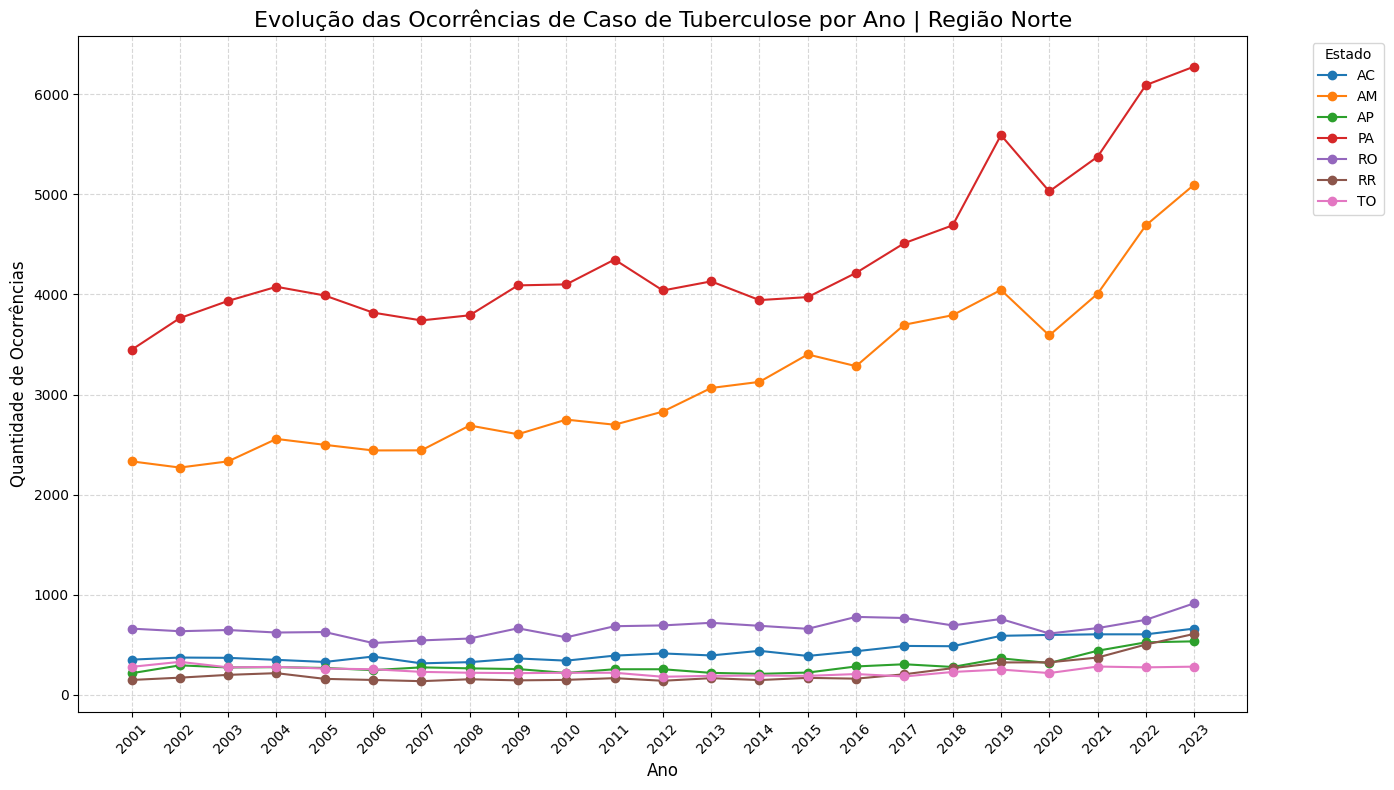

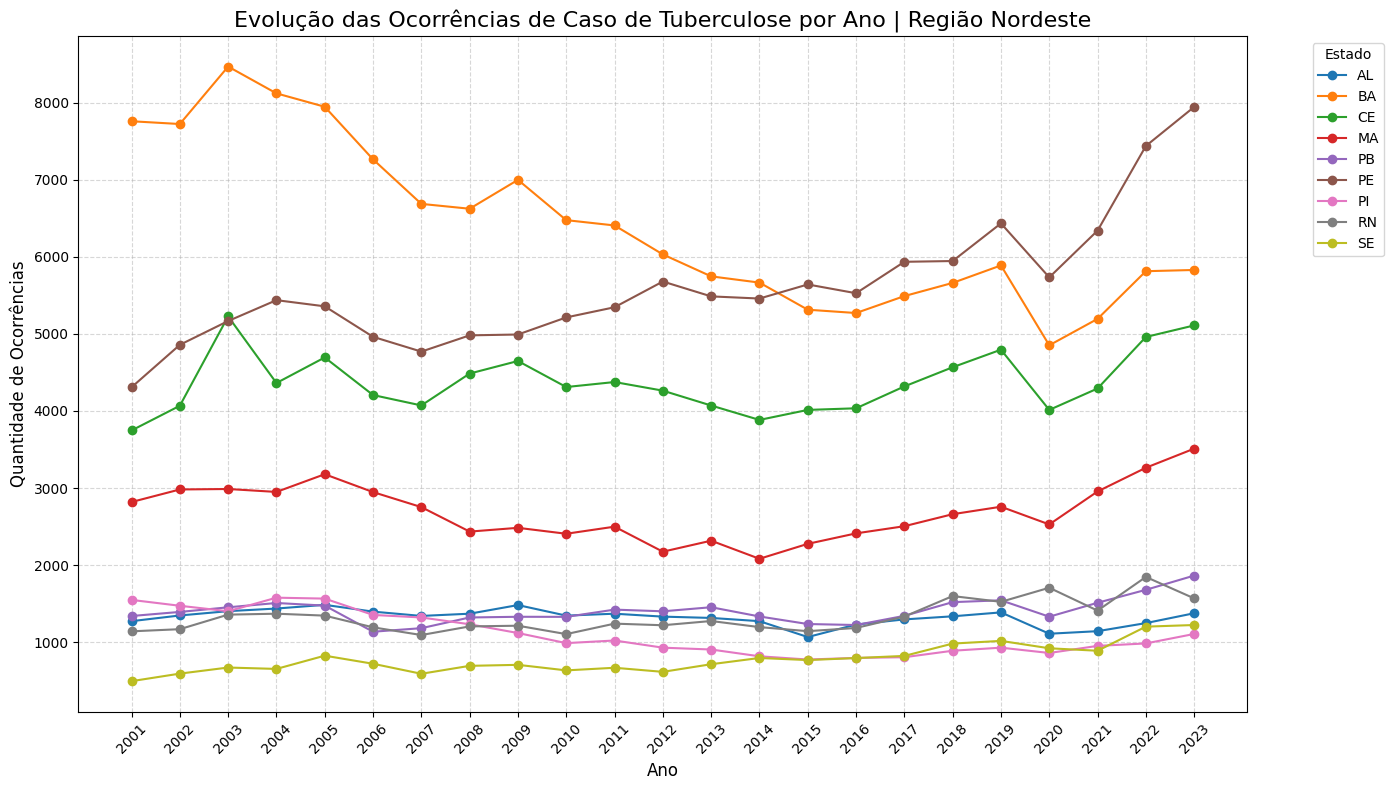

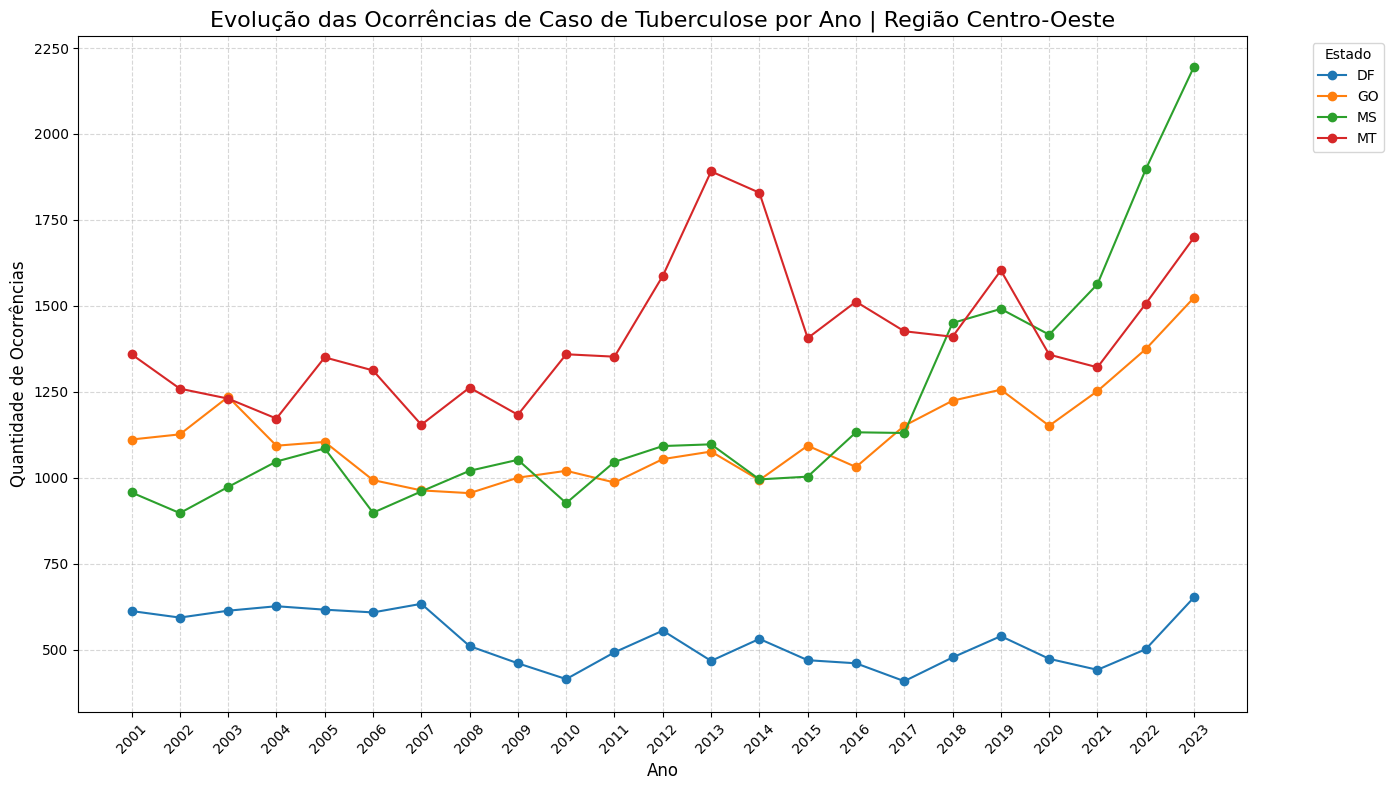

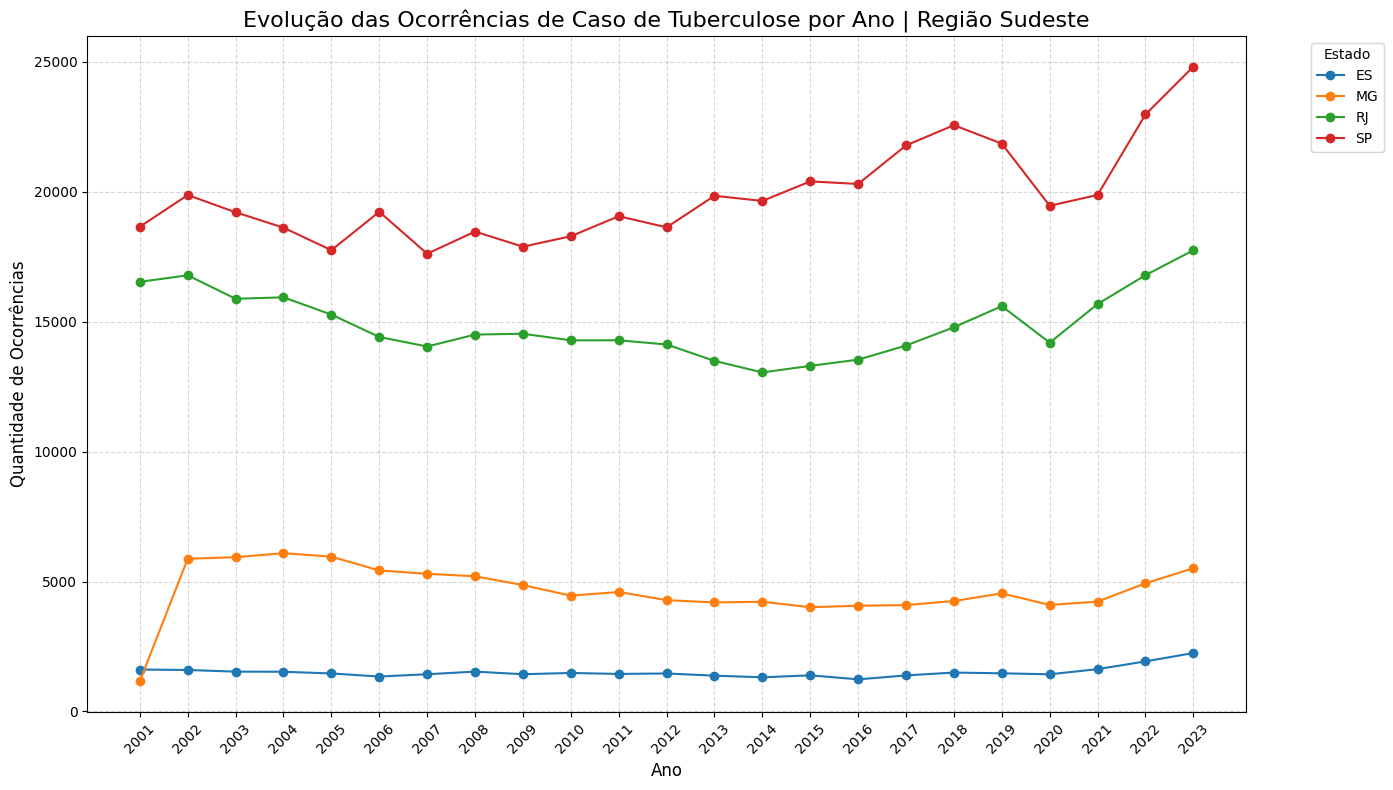

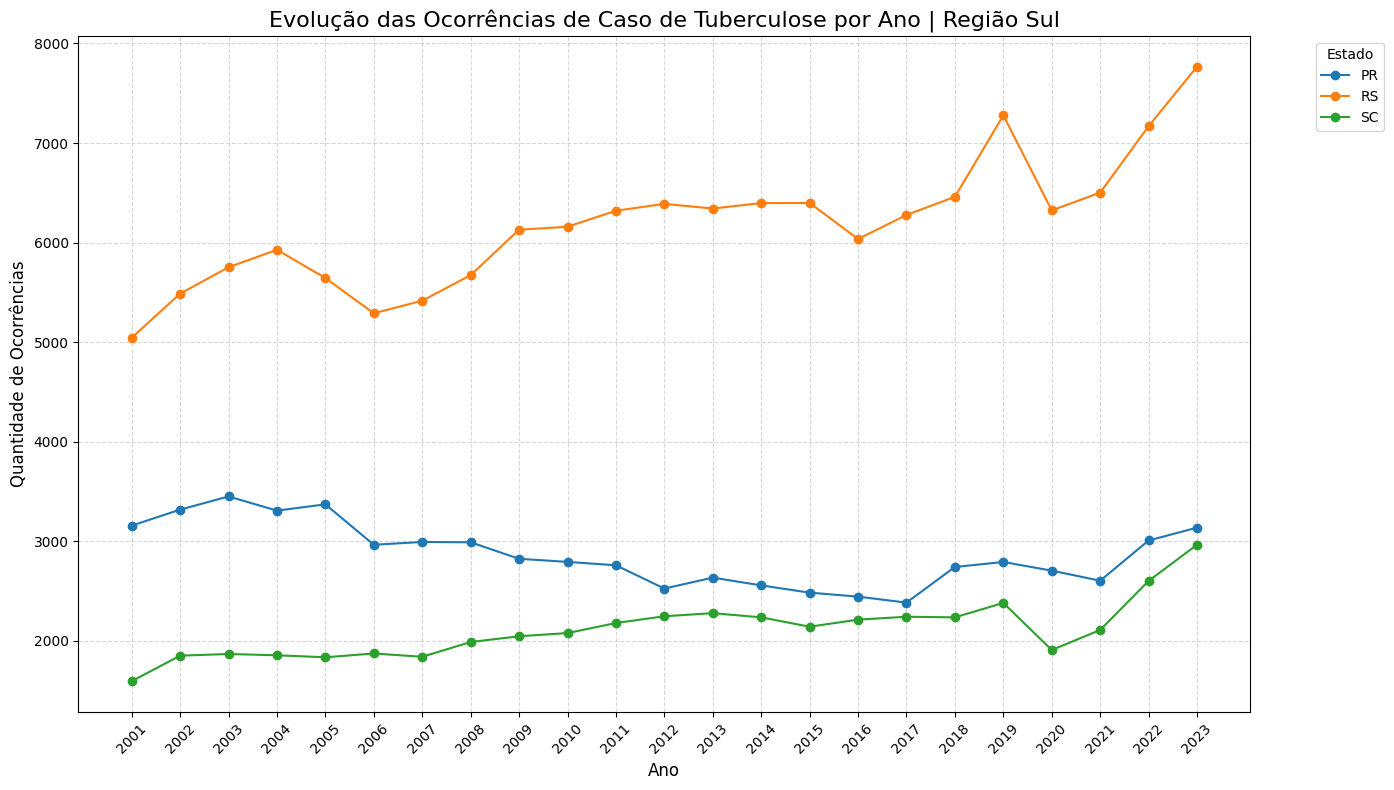

In [ ]:
# Criar DataFrame de estados
df_estados = pd.DataFrame(dados_est)

# Adicionar ao DataFrame original uma coluna para os nomes dos estados e regiões
df_dados_estado = df_dados.merge(df_estados[['id', 'sigla', 'regiao']], left_on='SG_UF_NOT', right_on='id', how='left')

# Filtrar para mostrar apenas os dados a partir de 2001 até 2023
df_dados_estado = df_dados_estado[(df_dados_estado['NU_ANO'] >= 2001) & (df_dados_estado['NU_ANO'] <= 2023)]
# Agrupar por ano, estado e região
dados_agrupados = df_dados_estado.groupby(['NU_ANO', 'sigla', 'regiao']).size().reset_index(name='quantidade')

# Obter lista única de regiões
regioes = dados_agrupados['regiao'].unique()

# Criar gráficos de linha para cada região
for regiao in regioes:
    fig, ax = plt.subplots(figsize=(14, 8))

    dados_regiao = dados_agrupados[dados_agrupados['regiao'] == regiao]

    for estado in dados_regiao['sigla'].unique():
        dados_estado = dados_regiao[dados_regiao['sigla'] == estado]
        ax.plot(
            dados_estado['NU_ANO'],
            dados_estado['quantidade'],
            marker='o',
            label=estado
        )

    # Configurar títulos e rótulos
    ax.set_title(f'Evolution of Tuberculosis Case Occurrences per Year | Region {regioes_brasil[regiao]}', fontsize=16)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of cases', fontsize=12)

    # Melhorar a visualização
    plt.xticks(dados_agrupados['NU_ANO'].unique(), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()

    # Exibir o gráfico para a região atual
    plt.show()


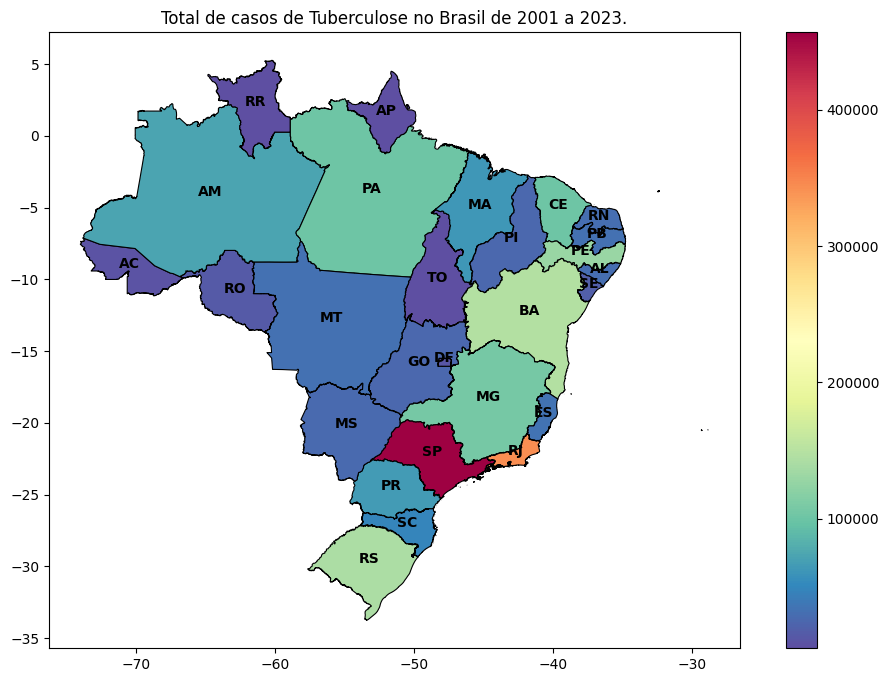

In [ ]:
#Plota o mapa do Brasil com a quantidade total de casos por estado
map = gpd.read_file("/content/drive/MyDrive/Material_mestrado/Séries Temporais/data/Mapa_Brasil_IBGE")
map["sigla"] = map["SIGLA_UF"].apply(lambda x: unidecode.unidecode(x).upper())


casos_por_estado = dados_agrupados.groupby('sigla')['quantidade'].sum().reset_index(name='Casos')
map = map.merge(casos_por_estado, on='sigla', how='left')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
map.plot(column="Casos", cmap="Spectral_r", linewidth=0.8, edgecolor="black", legend=True, ax=ax)
for idx, row in map.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["sigla"], fontsize=10, ha='center', color='black', fontweight="bold")

ax.set_title(f"Total Number of Tuberculosis Cases in Brazil Between 2001 and 2023.")
plt.show()

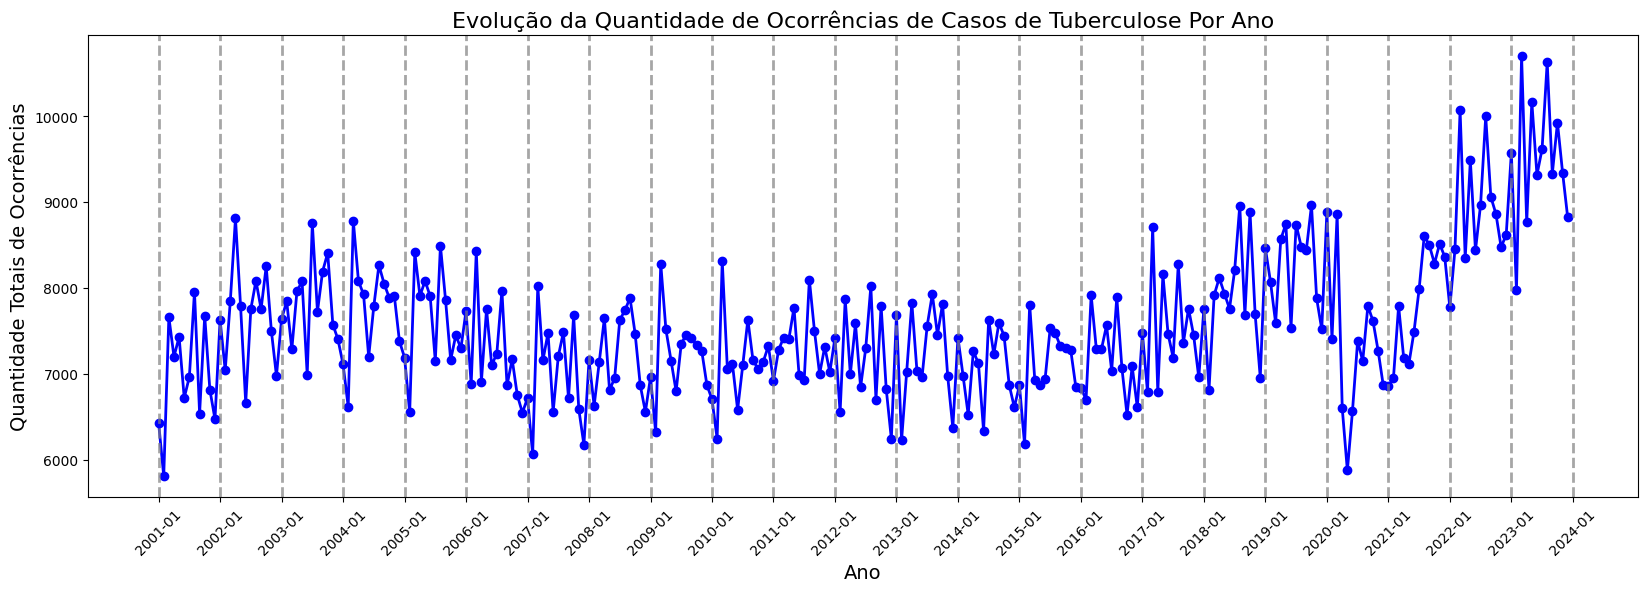

In [ ]:
# Converter a coluna DT_NOTIFIC para datetime
df_dados["DT_NOTIFIC"] = pd.to_datetime(df_dados["DT_NOTIFIC"], format='%Y%m%d', errors='coerce')

df_dados["ANO_MES"] = df_dados["DT_NOTIFIC"].dt.to_period("M").astype(str)
dados_agrupados = df_dados.groupby("ANO_MES").size().reset_index(name="quantidade")
dados_agrupados["ANO"] = dados_agrupados["ANO_MES"].str[:4]
#Organiza o dataset eliminandos os dados que não seram utilizados predição já que são anos fora do limite trabalhado.
dados_agrupados= dados_agrupados[dados_agrupados['ANO_MES'] >= '2000-01']
dados_agrupados= dados_agrupados[dados_agrupados['ANO_MES'] <= '2023-12']

# Gerar o gráfico
fig, ax = plt.subplots(figsize=(20, 6))

# Plotando o gráfico de séries temporais
# Use dados_filtrados DataFrame for plotting
ax.plot(
    dados_agrupados["ANO_MES"],
    dados_agrupados["quantidade"],
    marker='o',
    linestyle='-',
    linewidth=2,
    color='b'
)

# Adicionando os ticks do eixo X, incluindo o ano de 2024
xticks = dados_agrupados["ANO_MES"][::12].tolist()
xticks.append("2024-01")

ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45)

anos_unicos = sorted(dados_agrupados["ANO"].drop_duplicates().astype(int).tolist())  # Lista de anos numérica
anos_unicos.append(2024)

for ano in anos_unicos:
    ano_inicio = f"{ano}-01"
    ax.axvline(x=ano_inicio, color='gray', linestyle='--', linewidth=2, alpha=0.7)


ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of cases", fontsize=14)
ax.set_title("Evolution of the Number of Occurrences of Tuberculosis Cases per Year", fontsize=16)

plt.show()

###Decomposição Série Temporal para N° de Casos.

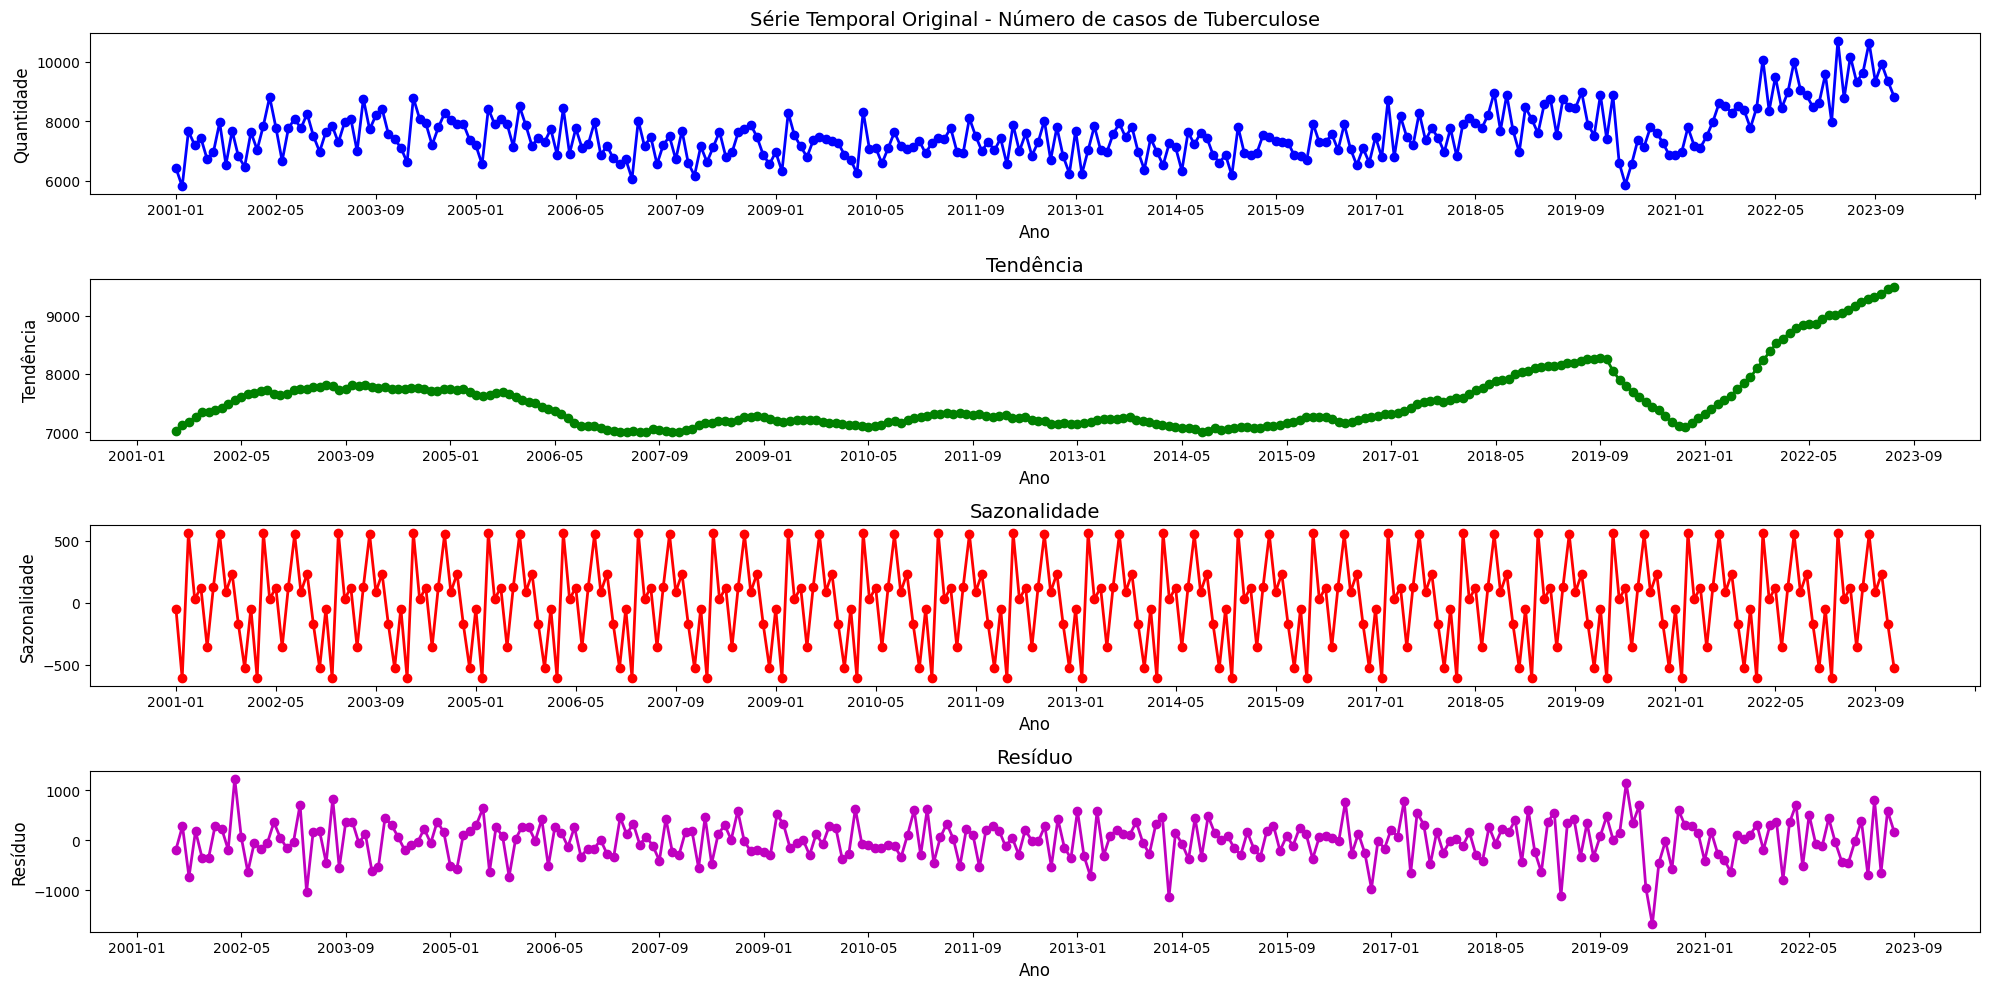

In [ ]:
from matplotlib.ticker import MultipleLocator

decompose = seasonal_decompose(dados_agrupados["quantidade"], model="additive", period=12)
tendencia = decompose.trend
sazonalidade = decompose.seasonal
residuo = decompose.resid

# Gerar o gráfico
fig, axes = plt.subplots(4, 1, figsize=(20, 10))

# Plotando a série temporal original
axes[0].plot(dados_agrupados["ANO_MES"], dados_agrupados["quantidade"], marker='o', linestyle='-', linewidth=2, color='b')
axes[0].set_title("Original Time Series - Number of cases of Tuberculosis", fontsize=14)
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Number of cases", fontsize=12)
axes[0].xaxis.set_major_locator(MultipleLocator(16))

# Plotando a tendência
axes[1].plot(dados_agrupados["ANO_MES"], tendencia, marker='o', linestyle='-', linewidth=2, color='g')
axes[1].set_title("Trend", fontsize=14)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Trend", fontsize=12)
axes[1].xaxis.set_major_locator(MultipleLocator(2))
axes[1].xaxis.set_major_locator(MultipleLocator(16))

# Plotando a sazonalidade
axes[2].plot(dados_agrupados["ANO_MES"], sazonalidade, marker='o', linestyle='-', linewidth=2, color='r')
axes[2].set_title("Seasonality", fontsize=14)
axes[2].set_xlabel("Year", fontsize=12)
axes[2].set_ylabel("Seasonality", fontsize=12)
axes[2].xaxis.set_major_locator(MultipleLocator(2))
axes[2].xaxis.set_major_locator(MultipleLocator(16))

# Plotando o resíduo
axes[3].plot(dados_agrupados["ANO_MES"], residuo, marker='o', linestyle='-', linewidth=2, color='m')
axes[3].set_title("Residue", fontsize=14)
axes[3].set_xlabel("Year", fontsize=12)
axes[3].set_ylabel("Residue", fontsize=12)
axes[3].set_axis_on()
axes[3].xaxis.set_major_locator(MultipleLocator(2))
axes[3].xaxis.set_major_locator(MultipleLocator(16))

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

plt.show()


###Processos de Previsão:

In [ ]:
pip install statsmodels

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
# Preparação dos Dados
dados_agrupados["ANO_MES"] = pd.to_datetime(dados_agrupados["ANO_MES"], format='%Y-%m')
dados_agrupados["ANO_MES_NUM"] = dados_agrupados["ANO_MES"].map(lambda x: x.toordinal())

# Filtro para ignorar dados antes de 2000
dados_filtrados = dados_agrupados[dados_agrupados["ANO_MES"] >= pd.to_datetime("2000-01")]

# Definição das variáveis independentes e dependentes
X = dados_filtrados[["ANO_MES_NUM"]].values
y = dados_filtrados["quantidade"].values

# Escalonamento dos dados
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Separar dados de treino e teste
limite_pandemia = pd.to_datetime("2020-03").toordinal()
X_treino = X_scaled[X[:, 0] < limite_pandemia]
y_treino = y_scaled[X[:, 0] < limite_pandemia]
X_teste = X_scaled[X[:, 0] >= limite_pandemia]
y_teste = y_scaled[X[:, 0] >= limite_pandemia]

# Função para reverter escalonamento
def inverter_escalonamento(y_pred_scaled):
    return scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))



In [ ]:
print (y_treino)

[[0.12648141]
 [0.        ]
 [0.37821823]
 [0.28422558]
 [0.33101757]
 [0.18594197]
 [0.23579894]
 [0.43890478]
 [0.14875358]
 [0.38107887]
 [0.20576216]
 [0.13526767]
 [0.37127094]
 [0.25153249]
 [0.41765427]
 [0.6136085 ]
 [0.40375971]
 [0.17388639]
 [0.39762975]
 [0.46485492]
 [0.39742542]
 [0.49918267]
 [0.34634246]
 [0.23804659]
 [0.37413159]
 [0.41561095]
 [0.30159379]
 [0.44013077]
 [0.4634246 ]
 [0.24090723]
 [0.60155292]
 [0.39129546]
 [0.48671843]
 [0.53105844]
 [0.36064569]
 [0.32550061]
 [0.26563139]
 [0.16510012]
 [0.60768288]
 [0.46424193]
 [0.43216183]
 [0.28381692]
 [0.4043727 ]
 [0.50204332]
 [0.45811197]
 [0.42480588]
 [0.42930119]
 [0.32100531]
 [0.28197793]
 [0.15140989]
 [0.53248876]
 [0.42868819]
 [0.46444626]
 [0.42827953]
 [0.27319166]
 [0.54842664]
 [0.41908459]
 [0.27625664]
 [0.33510421]
 [0.30404577]
 [0.39333878]
 [0.21802207]
 [0.53555374]
 [0.22496935]
 [0.39742542]
 [0.26420106]
 [0.2907642 ]
 [0.44135676]
 [0.21577442]
 [0.27809563]
 [0.19248059]
 [0.15

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

dados_agrupados['ANO_MES'] = pd.to_datetime(dados_agrupados['ANO_MES'])
dados_agrupados['ANO_MES_ORDINAL'] = dados_agrupados['ANO_MES'].apply(lambda date: date.toordinal())
dados_agrupados['quantidade'] = pd.to_numeric(dados_agrupados['quantidade'], errors='coerce')


dados_agrupados = dados_agrupados.dropna(subset=['quantidade'])
modelo_auto_arima = auto_arima(dados_agrupados['quantidade'],
                               X=dados_agrupados[['ANO_MES_ORDINAL']],
                               seasonal=True,
                               m=12,
                               stepwise=True,
                               trace=True)

print(modelo_auto_arima.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4254.695, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4416.230, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4312.287, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4263.513, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4479.383, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4272.051, Time=2.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4263.092, Time=0.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=4256.857, Time=2.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=4254.221, Time=2.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=4272.494, Time=2.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=4244.858, Time=3.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=4261.100, Time=2.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=4246.593, Time=2.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=4242.116, Time=3.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,2)[12] intercept   : AIC=4249.278, Time=3.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,1)[12] intercept   : AIC=4263.674, Time=2.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=4248.411, Time=1.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[12] intercept   : AIC=4246.887, Time=2.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=5.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(2,0,2)[12] intercept   : AIC=4245.638, Time=3.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[12] intercept   : AIC=4242.294, Time=3.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,2)[12] intercept   : AIC=4241.317, Time=3.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,2)[12] intercept   : AIC=4249.356, Time=3.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,1)[12] intercept   : AIC=4252.925, Time=3.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,1)[12] intercept   : AIC=4252.160, Time=1.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,2)[12] intercept   : AIC=4238.349, Time=3.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[12] intercept   : AIC=4247.449, Time=3.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,1)[12] intercept   : AIC=4250.002, Time=2.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[12] intercept   : AIC=4237.009, Time=1.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[12] intercept   : AIC=4270.043, Time=0.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,0)[12] intercept   : AIC=4258.515, Time=1.05 sec
 ARIMA(4,1,0)(0,0,0)[12] intercept   : AIC=4322.899, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,2)[12] intercept   : AIC=4271.050, Time=1.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,0)[12] intercept   : AIC=4260.849, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=4254.267, Time=2.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,1)[12] intercept   : AIC=4248.653, Time=1.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[12] intercept   : AIC=4251.584, Time=1.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[12] intercept   : AIC=4246.339, Time=1.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[12]             : AIC=4230.329, Time=0.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[12]             : AIC=4268.570, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,0)[12]             : AIC=4259.428, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,1)[12]             : AIC=4233.829, Time=2.71 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(4,1,0)(0,0,0)[12]             : AIC=4321.446, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,2)[12]             : AIC=4269.549, Time=1.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,0)[12]             : AIC=4259.192, Time=1.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,2)[12]             : AIC=4226.791, Time=2.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[12]             : AIC=4239.324, Time=2.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,2)[12]             : AIC=4226.020, Time=4.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,2)[12]             : AIC=4228.204, Time=2.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,1)[12]             : AIC=4229.348, Time=2.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,1)[12]             : AIC=4227.425, Time=1.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,2)[12]             : AIC=4228.140, Time=3.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,2)[12]             : AIC=4228.476, Time=4.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,2)[12] intercept   : AIC=4238.223, Time=3.78 sec

Best model:  ARIMA(5,1,0)(2,0,2)[12]          
Total fit time: 121.449 seconds
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  276
Model:             SARIMAX(5, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -2102.010
Date:                                 Mon, 03 Mar 2025   AIC                           4226.020
Time:                                         23:29:15   BIC                           4265.805
Sample:                                              0   HQIC                          4241.987
                                                 - 276                                         
Covariance Type:                                   opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


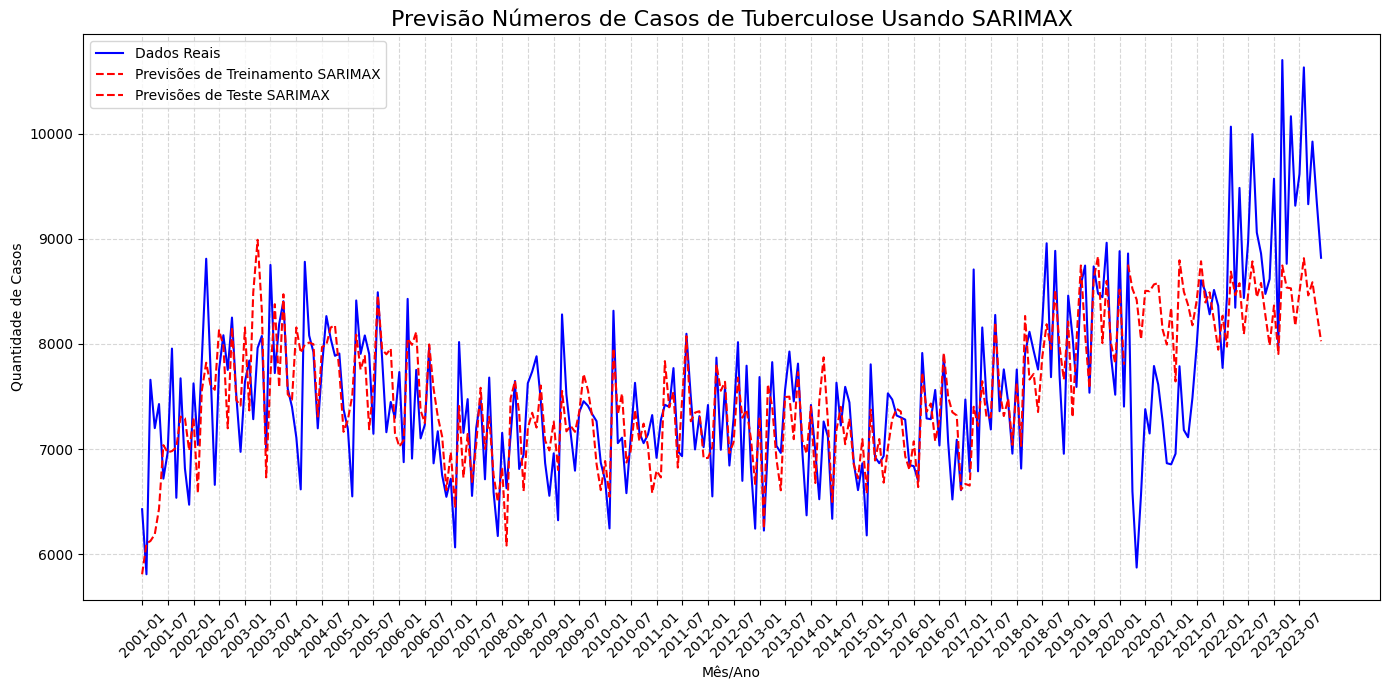

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Treinando o modelo SARIMAX
modelo_sarima = SARIMAX(y_treino, order=(5, 1, 0), seasonal_order=(2, 0, 2, 12),
                        enforce_stationarity=False, enforce_invertibility=False)

modelo_sarima_fit = modelo_sarima.fit(disp=False)
train_pred_sarimax = modelo_sarima_fit.predict(start=0, end=len(y_treino)-1)

# Cálculo das métricas de desempenho para o conjunto de treinamento
mae_train_sx = mean_absolute_error(y_treino, train_pred_sarimax)
mse_train_sx = mean_squared_error(y_treino, train_pred_sarimax)
rmse_train_sx = np.sqrt(mse_train_sx)

#Fazendo previsões:
forecast_sarimax = modelo_sarima_fit.forecast(steps=(len(dados_filtrados) - len(y_treino)))

# Revertendo o escalonamento das previsões
train_pred_sarimax_inverted = inverter_escalonamento(train_pred_sarimax)
forecast_sarimax_inverted = inverter_escalonamento(forecast_sarimax)
all_previsions = np.concatenate((train_pred_sarimax_inverted, forecast_sarimax_inverted))
mae_test_sx = mean_absolute_error(y, all_previsions)
mse_test_sx = mean_squared_error(y, all_previsions)
rmse_test_sx = np.sqrt(mse_test_sx)

# Criando a linha do tempo para previsões
datas_treino = dados_filtrados["ANO_MES"][:len(train_pred_sarimax_inverted)]
datas_teste = pd.date_range(start=datas_treino.iloc[-1], periods=len(forecast_sarimax_inverted) + 1, freq="MS")[1:]

plt.figure(figsize=(14, 7))

# Ajustando o gráfico de previsões
plt.plot(dados_filtrados["ANO_MES"], dados_filtrados["quantidade"], label="Real data", color="blue")

# Previsões de treinamento
plt.plot(datas_treino, train_pred_sarimax_inverted, label="SARIMAX Predictions", color="red", linestyle="--")

# Previsões de teste
plt.plot(datas_teste, forecast_sarimax_inverted,color="red", linestyle="--")

# Ajustando o título e os rótulos
plt.title("Predicting Numbers of Tuberculosis Cases Using SARIMAX", fontsize=16)
plt.xlabel("Month/Year")
plt.ylabel("Number of cases")

# Ajustando as ticks do eixo X para mostrar de 6 em 6 meses dentro do intervalo
xticks = pd.date_range(start=dados_filtrados["ANO_MES"].min(), end=dados_filtrados["ANO_MES"].max(), freq="6MS")
plt.xticks(xticks, labels=[tick.strftime('%Y-%m') for tick in xticks], rotation=45)

# Exibindo legenda e grade
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Exibindo o gráfico
plt.show()


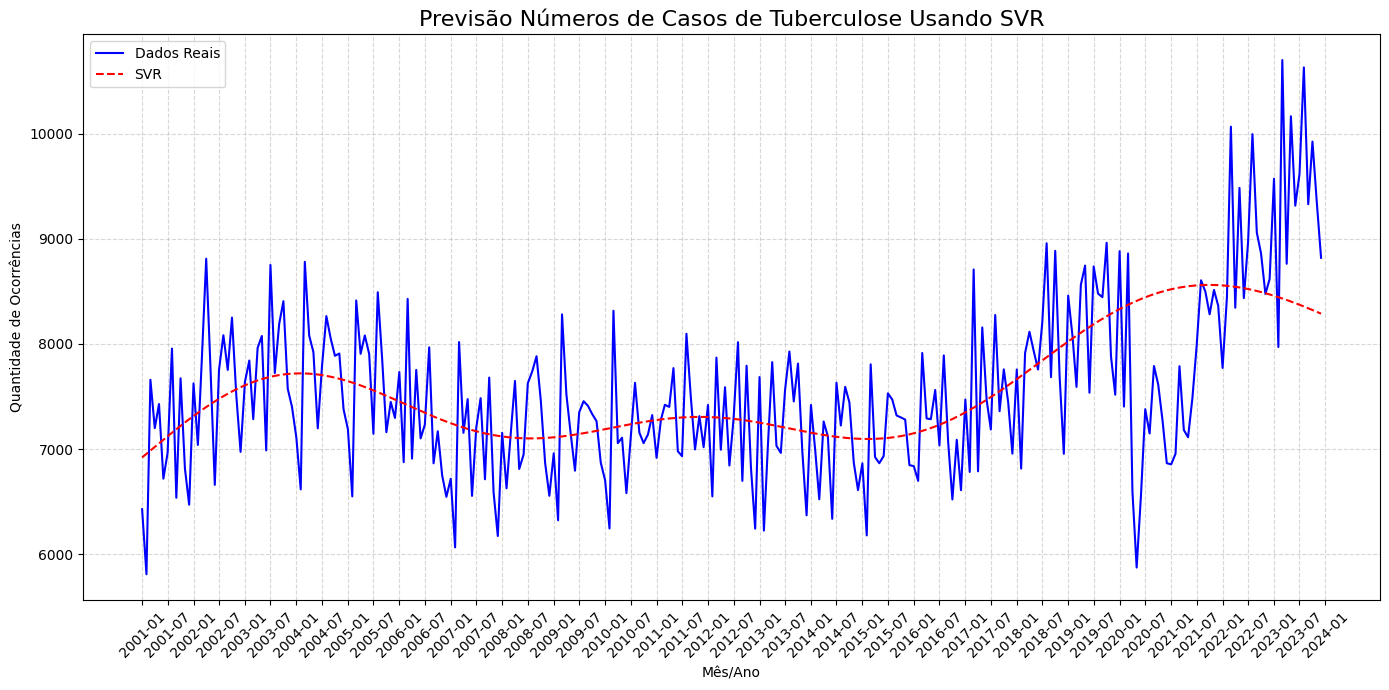

In [ ]:
#Treinando com Suporte a Vetores de Regressão (SVR)
modelo_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
modelo_svr.fit(X_treino, y_treino.ravel())

# Fazendo previsões no conjunto de treinamento
train_pred_svr_scaled = modelo_svr.predict(X_treino)
train_pred_svr = inverter_escalonamento(train_pred_svr_scaled)

#Avalia o desempenho durante o treinamento
mae_train_SVR = mean_absolute_error(y_treino, train_pred_svr_scaled)
mse_train_SVR = mean_squared_error(y_treino, train_pred_svr_scaled)
rmse_train_SVR = np.sqrt(mse_train_SVR)

dados_filtrados = dados_agrupados[dados_agrupados["ANO_MES"] >= pd.to_datetime("2000-01")]
dados_filtrados["ANO_MES_NUM"] = dados_filtrados["ANO_MES"].map(lambda x: x.toordinal())
X_scaled_filtered = scaler_X.transform(dados_filtrados[["ANO_MES_NUM"]].values)
y_pred_svr_scaled = modelo_svr.predict(X_scaled_filtered)
y_pred_svr = inverter_escalonamento(y_pred_svr_scaled)

#Avalia o desempenho alcançado durante o teste.
mae_test_SVR = mean_absolute_error(y, y_pred_svr)
mse_test_SVR = mean_squared_error(y, y_pred_svr)
rmse_test_SVR = np.sqrt(mse_test_SVR)

plt.figure(figsize=(14, 7))

# Ensure both x and y have the same length for plotting
plt.plot(dados_filtrados["ANO_MES"], dados_filtrados["quantidade"], label="Real data", color="blue")
plt.plot(dados_filtrados["ANO_MES"], y_pred_svr, label=f"SVR", color="red", linestyle="--")

plt.title(f"Predicting Numbers of Tuberculosis Cases Using SVR", fontsize=16)
plt.xlabel("Month/Year")
plt.ylabel("Number of cases")
xticks = pd.date_range(dados_agrupados["ANO_MES"].min(), dados_agrupados["ANO_MES"].max(), freq="6MS")
xticks = xticks.append(pd.DatetimeIndex([pd.Timestamp("2024-01")]))
plt.xticks(xticks, labels=[tick.strftime('%Y-%m') for tick in xticks], rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

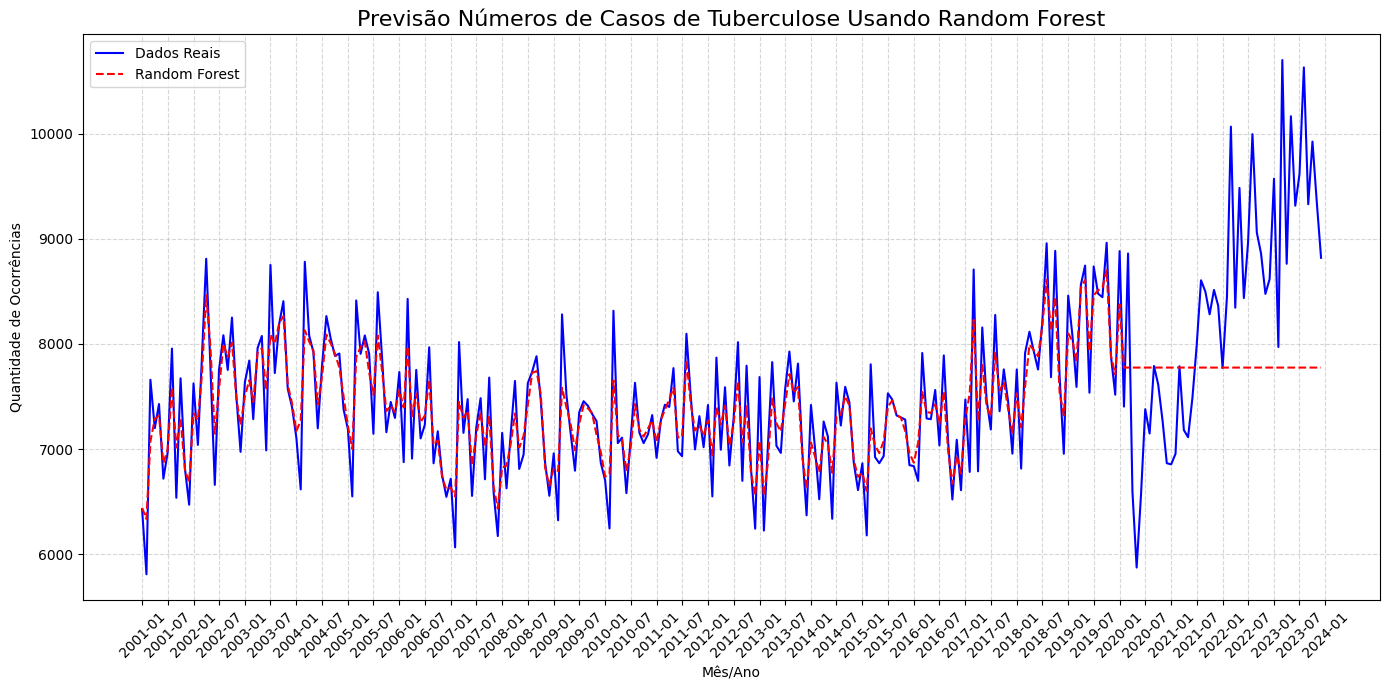

In [ ]:
# Previsão usando Random Forest

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_treino, y_treino.ravel())
y_pred_rf = inverter_escalonamento(modelo_rf.predict(X_scaled))

# Previsões no conjunto de treinamento
train_pred_rf_scaled = modelo_rf.predict(X_treino)
train_pred_rf = inverter_escalonamento(train_pred_rf_scaled)

# Cálculo das métricas de desempenho para o conjunto de treinamento
mae_train_rf = mean_absolute_error(y_treino, train_pred_rf_scaled)
mse_train_rf = mean_squared_error(y_treino, train_pred_rf_scaled)
rmse_train_rf = np.sqrt(mse_train_rf)

# Cálculo das métricas de desempenho para o conjunto de teste
y_test = dados_filtrados["quantidade"].values
mae_test_rf = mean_absolute_error(y_test, y_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_rf)
rmse_test_rf = np.sqrt(mse_test_rf)

plt.figure(figsize=(14, 7))

# Ensure both x and y have the same length for plotting
plt.plot(dados_filtrados["ANO_MES"], dados_filtrados["quantidade"], label="Dados Reais", color="blue")
plt.plot(dados_filtrados["ANO_MES"], y_pred_rf, label=f"Random Forest", color="red", linestyle="--")

plt.title(f"Predicting Numbers of Tuberculosis Cases Using Random Forest", fontsize=16)
plt.xlabel("Month/Year")
plt.ylabel("Number of cases")
xticks = pd.date_range(dados_agrupados["ANO_MES"].min(), dados_agrupados["ANO_MES"].max(), freq="6MS")
xticks = xticks.append(pd.DatetimeIndex([pd.Timestamp("2024-01")]))
plt.xticks(xticks, labels=[tick.strftime('%Y-%m') for tick in xticks], rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

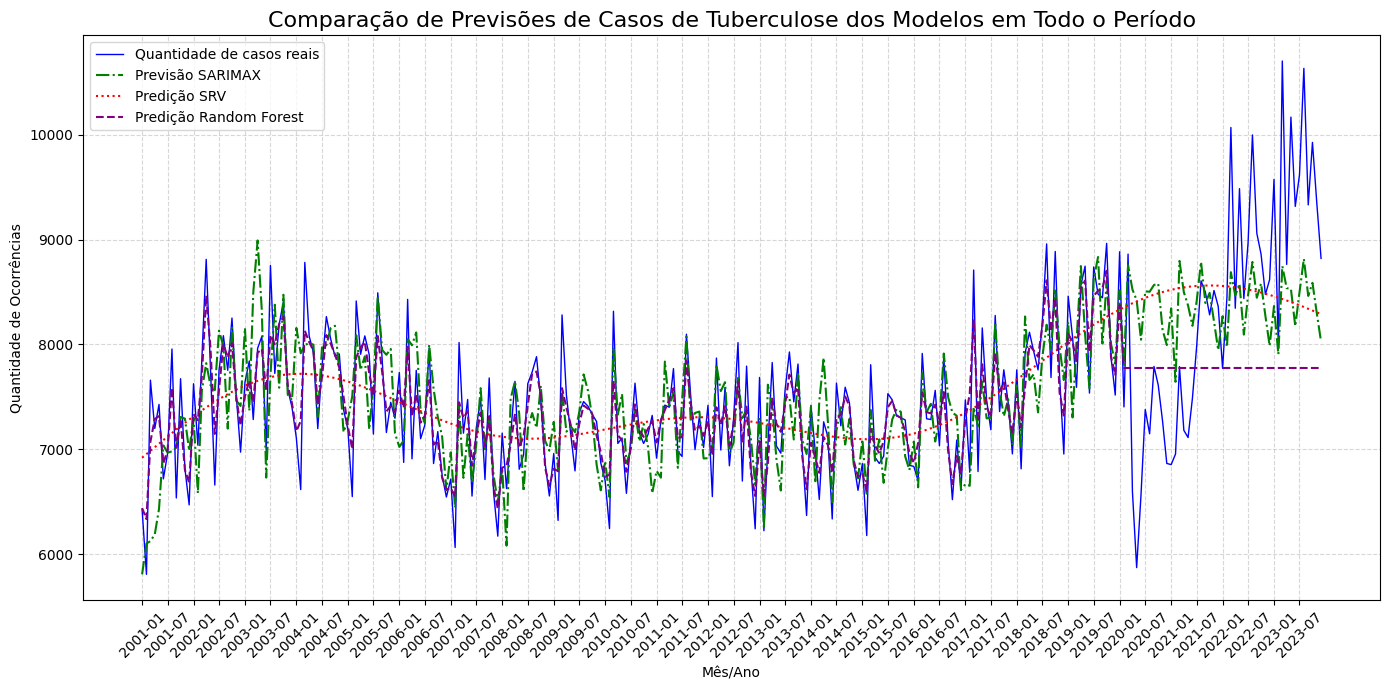

In [ ]:
# Plotar os resultados (todo o período)
plt.figure(figsize=(14, 7))

# Dados reais
plt.plot(dados_agrupados["ANO_MES"],y, label="Quantidade de casos reais", color="blue", linewidth=1)

# Previsões
#plt.plot(dados_agrupados["ANO_MES"], result_Arima, label="Previsão ARIMA", color="red", linestyle="--")
plt.plot(dados_agrupados["ANO_MES"], all_previsions, label="Previsão SARIMAX", color="green", linestyle="-.")
plt.plot(dados_agrupados["ANO_MES"], y_pred_svr, label="Predição SRV", color="red", linestyle=":")
plt.plot(dados_agrupados["ANO_MES"], y_pred_rf , label="Predição Random Forest", color="purple", linestyle="--")

# Adicionar informações ao gráfico
plt.title("Comparison of Models Tuberculosis Cases Predictions Across the Period", fontsize=16)
plt.xlabel("Mês/Ano")
plt.ylabel("Quantidade de Ocorrências")
xticks = pd.date_range(dados_agrupados["ANO_MES"].min(), dados_agrupados["ANO_MES"].max(), freq="6MS")
plt.xticks(xticks, labels=[tick.strftime('%Y-%m') for tick in xticks], rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#Exibe os resultados obtidos para as métricas de desempenho:
print("----------------------------------")
print("Métricas de desempenho durante o treinamento:")
print("----------------------------------")
print(f"MAE SARIMAX:",mae_train_sx )
print(f"MAE SRV:", mae_train_SVR )
print(f"MAE Random Forest:",mae_train_rf)
print("----------------------------------")
print(f"MSE SARIMAX:",mse_train_sx )
print(f"MSE SRV:", mse_train_SVR )
print(f"MSE Random Forest:",mse_train_rf)
print("----------------------------------")
print(f"RMSE SARIMAX:", rmse_train_sx)
print(f"RMSE SRV:", rmse_train_SVR )
print(f"RMSE Random Forest:",rmse_train_rf)
print("\n")
print("----------------------------------")
print("Métricas de desempenho para todo o período:")
print("----------------------------------")
print(f"MAE SARIMAX:",mae_test_sx )
print(f"MAE SRV:", mae_test_SVR )
print(f"MAE Random Forest:",mae_test_rf)
print("----------------------------------")
print(f"MSE SARIMAX:",mse_test_sx )
print(f"MSE SRV:", mse_test_SVR )
print(f"MSE Random Forest:",mse_test_rf)
print("----------------------------------")
print(f"RMSE SARIMAX:", rmse_test_sx)
print(f"RMSE SRV:", rmse_test_SVR )
print(f"RMSE Random Forest:",rmse_test_rf)

----------------------------------
Métricas de desempenho durante o treinamento:
----------------------------------
MAE SARIMAX: 0.07096550542661803
MAE SRV: 0.08889444987129261
MAE Random Forest: 0.04173249409214477
----------------------------------
MSE SARIMAX: 0.008288779889987405
MSE SRV: 0.011560532314534371
MSE Random Forest: 0.002910359788076509
----------------------------------
RMSE SARIMAX: 0.10751991589716935
RMSE SRV: 0.10751991589716935
RMSE Random Forest: 0.05394775053768701


----------------------------------
Métricas de desempenho para todo o período:
----------------------------------
MAE SARIMAX: 437.0714162288051
MAE SRV: 521.1948407499855
MAE Random Forest: 347.68496376811584
----------------------------------
MSE SARIMAX: 350972.8323880637
MSE SRV: 455696.32258538867
MSE Random Forest: 336936.2458960143
----------------------------------
RMSE SARIMAX: 592.4296012085011
RMSE SRV: 675.0528294773593
RMSE Random Forest: 580.4620968642262


###Análise Considerando o Número de Óbitos

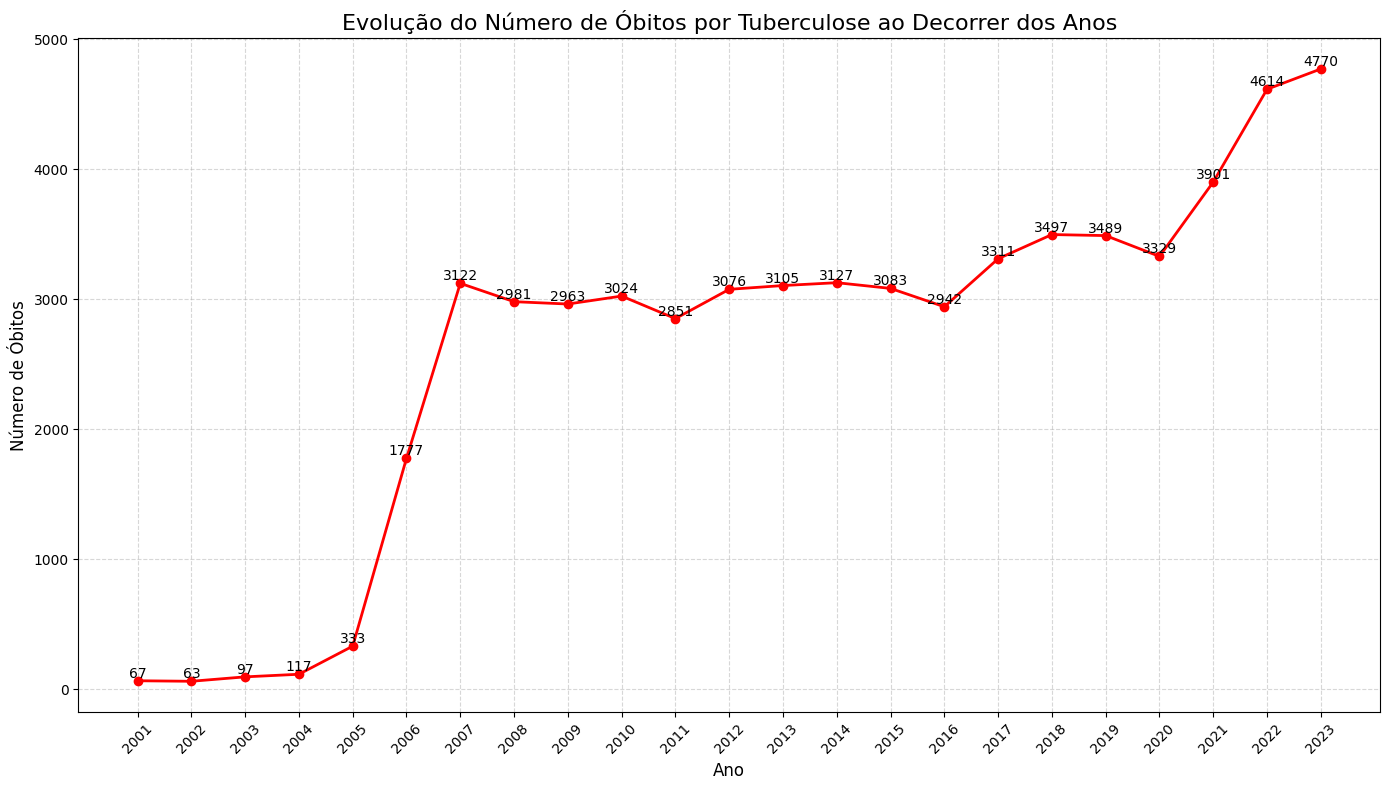

In [ ]:
# Filtrar os dados para considerar apenas óbitos (TP_SITUACAO_ENCERRAMENTO == 3)
df_obitos = df_dados[df_dados['SITUA_ENCE'] == 3]

df_obitos = df_obitos[(df_obitos['NU_ANO'] >= 2001) & (df_obitos['NU_ANO'] <= 2023)]

# Agrupar os dados por ano e contar a quantidade de óbitos
dados_agrupados_obitos = df_obitos.groupby('NU_ANO').size().reset_index(name='quantidade_obitos')

# Criar o gráfico de linha
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(
    dados_agrupados_obitos['NU_ANO'],
    dados_agrupados_obitos['quantidade_obitos'],
    marker='o',
    linestyle='-',
    linewidth=2,
    color='r'  # Cor vermelha para óbitos
)

# Adicionar os números de óbitos nos pontos do gráfico
for i, txt in enumerate(dados_agrupados_obitos['quantidade_obitos']):
    ax.annotate(txt, (dados_agrupados_obitos['NU_ANO'][i], dados_agrupados_obitos['quantidade_obitos'][i]),
                fontsize=10, ha='center', va='bottom')

# Configurar título e rótulos dos eixos
ax.set_title('Evolution of the Number of Deaths from Tuberculosis Over the Years', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Deaths', fontsize=12)

# Melhorar a visualização
plt.xticks(dados_agrupados_obitos['NU_ANO'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Exibir o gráfico
plt.tight_layout()
plt.show()

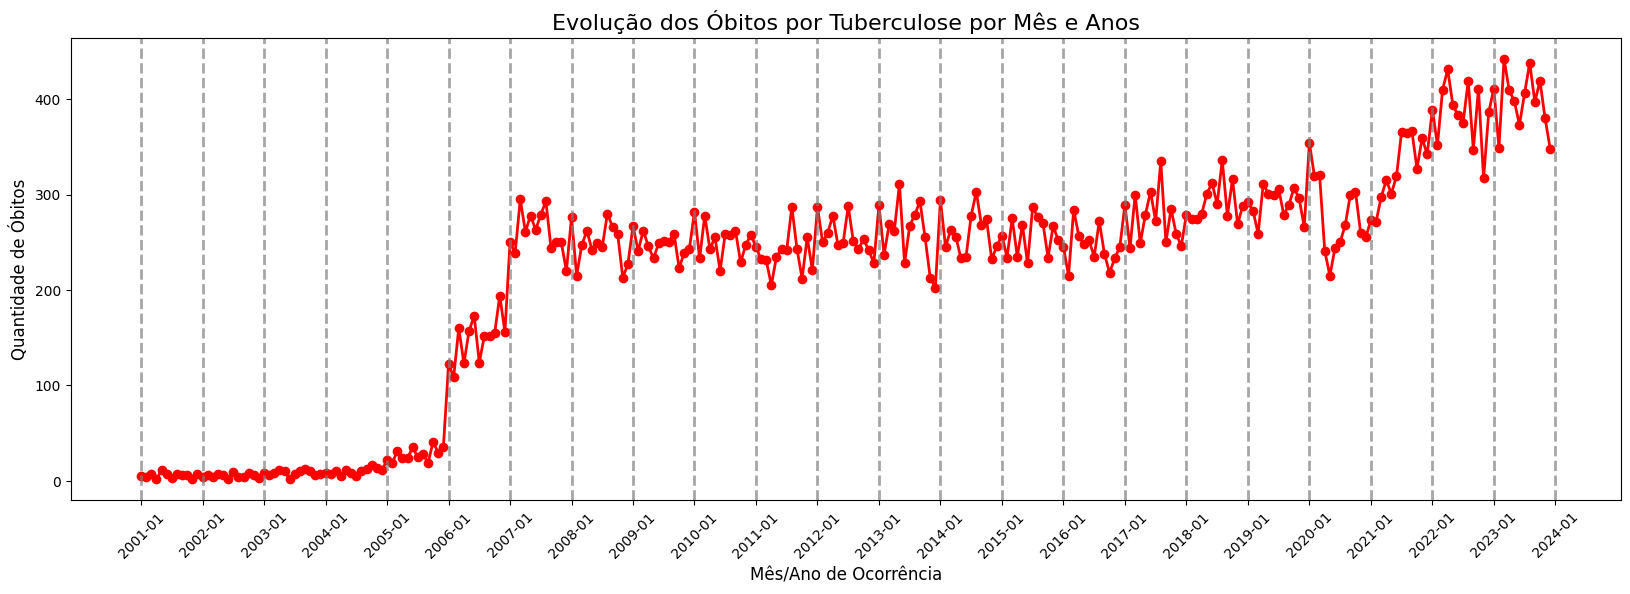

In [ ]:
# Converter a coluna DT_NOTIFIC para datetime
# Filtrar os dados para considerar apenas óbitos ('SITUA_ENCE' == 3)
df_obitos = df_dados[df_dados['SITUA_ENCE'] == 3].copy()
df_obitos = df_obitos[(df_obitos['NU_ANO'] >= 2001) & (df_obitos['NU_ANO'] <= 2023)]

# Converter a coluna DT_NOTIFIC para datetime
df_obitos.loc[:, "DT_NOTIFIC"] = pd.to_datetime(df_obitos["DT_NOTIFIC"], format='%Y%m%d', errors='coerce')

# Criar uma nova coluna no formato "AAAA-MM"
df_obitos.loc[:, "ANO_MES"] = df_obitos["DT_NOTIFIC"].dt.to_period("M").astype(str)

# Agrupar os dados por "ANO_MES" e contar a quantidade de óbitos
dados_agrupados_obitos = df_obitos.groupby("ANO_MES").size().reset_index(name="quantidade_obitos")

# Detectar mudanças de ano para adicionar linhas verticais
dados_agrupados_obitos["ANO"] = dados_agrupados_obitos["ANO_MES"].str[:4]
anos_unicos = dados_agrupados_obitos["ANO"].drop_duplicates().index

# Gerar o gráfico
fig, ax = plt.subplots(figsize=(20, 6))

# Plotando o gráfico de séries temporais
ax.plot(
    dados_agrupados_obitos["ANO_MES"],
    dados_agrupados_obitos["quantidade_obitos"],
    marker='o',
    linestyle='-',
    linewidth=2,
    color='r'
)

# Adicionando os ticks do eixo X, incluindo o ano de 2024
xticks = dados_agrupados_obitos["ANO_MES"][::12].tolist() # Changed to dados_agrupados_obitos
xticks.append("2024-01")

ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45)

anos_unicos = sorted(dados_agrupados_obitos["ANO"].drop_duplicates().astype(int).tolist())  # Lista de anos numérica
anos_unicos.append(2024)

for ano in anos_unicos:
    ano_inicio = f"{ano}-01"
    ano_inicio_dt = pd.to_datetime(ano_inicio, format='%Y-%m').strftime('%Y-%m')
    ax.axvline(x=ano_inicio_dt, color='gray', linestyle='--', linewidth=2, alpha=0.7)


ax.set_title("Evolution of Deaths from Tuberculosis by Month and Year", fontsize=16)
ax.set_xlabel("Month/Year of Occurrence", fontsize=12)
ax.set_ylabel("Number of Deaths", fontsize=12)


plt.show()

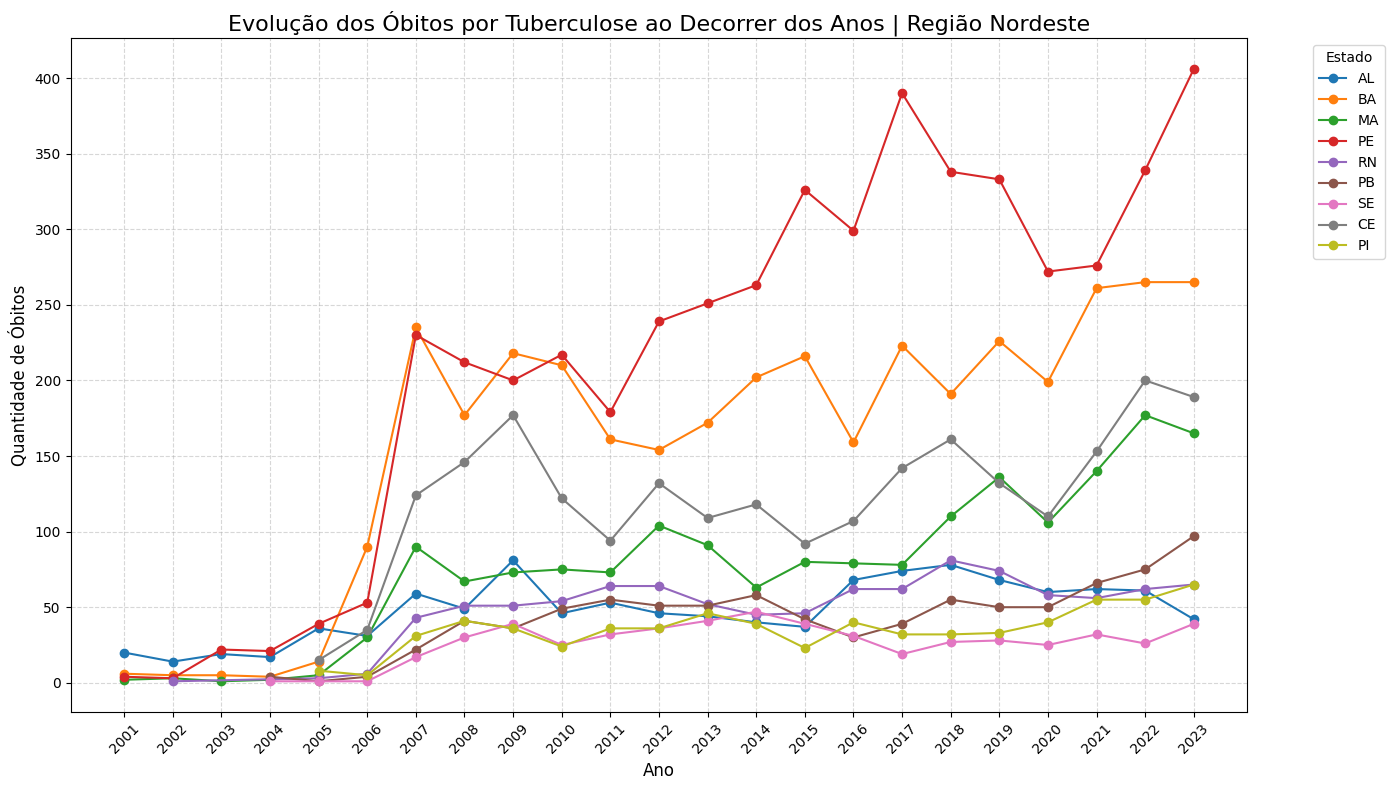

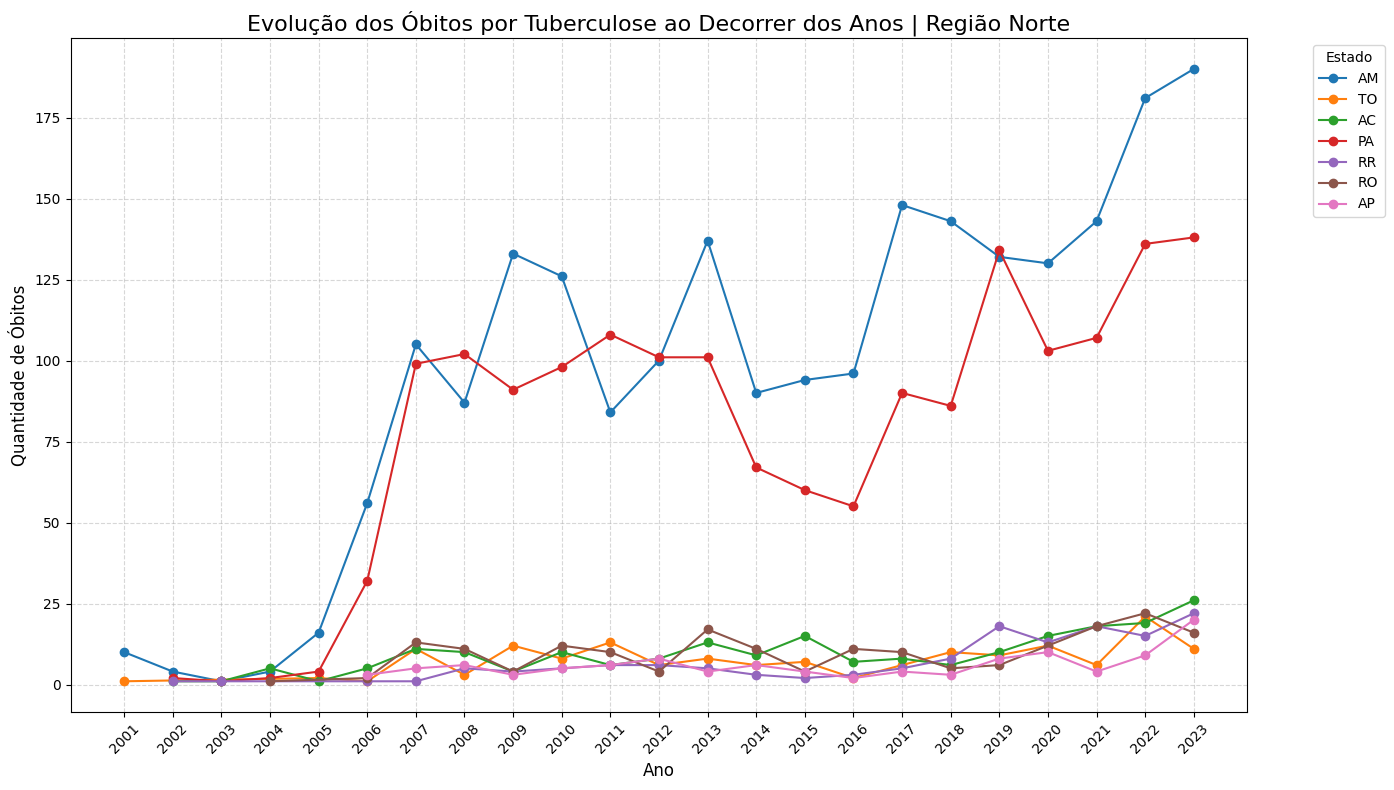

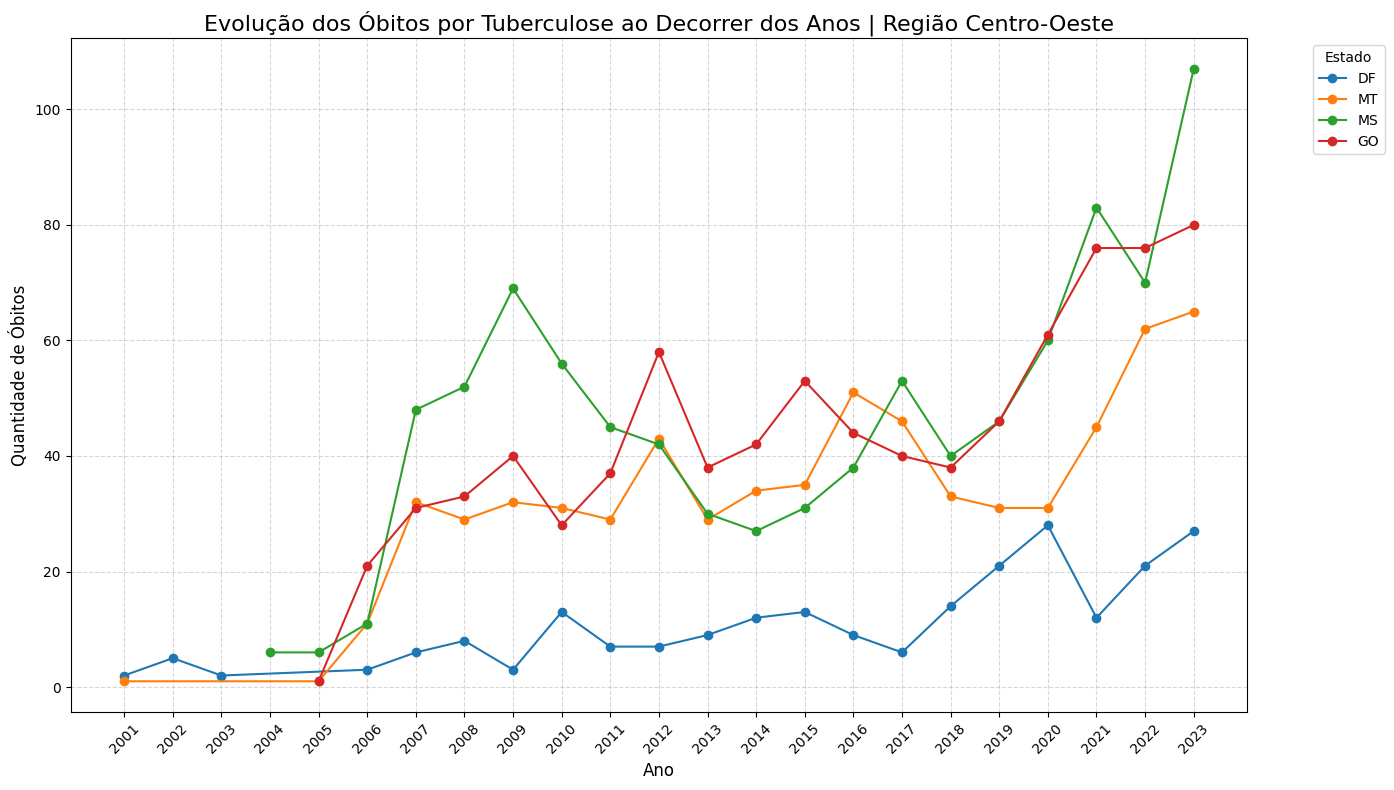

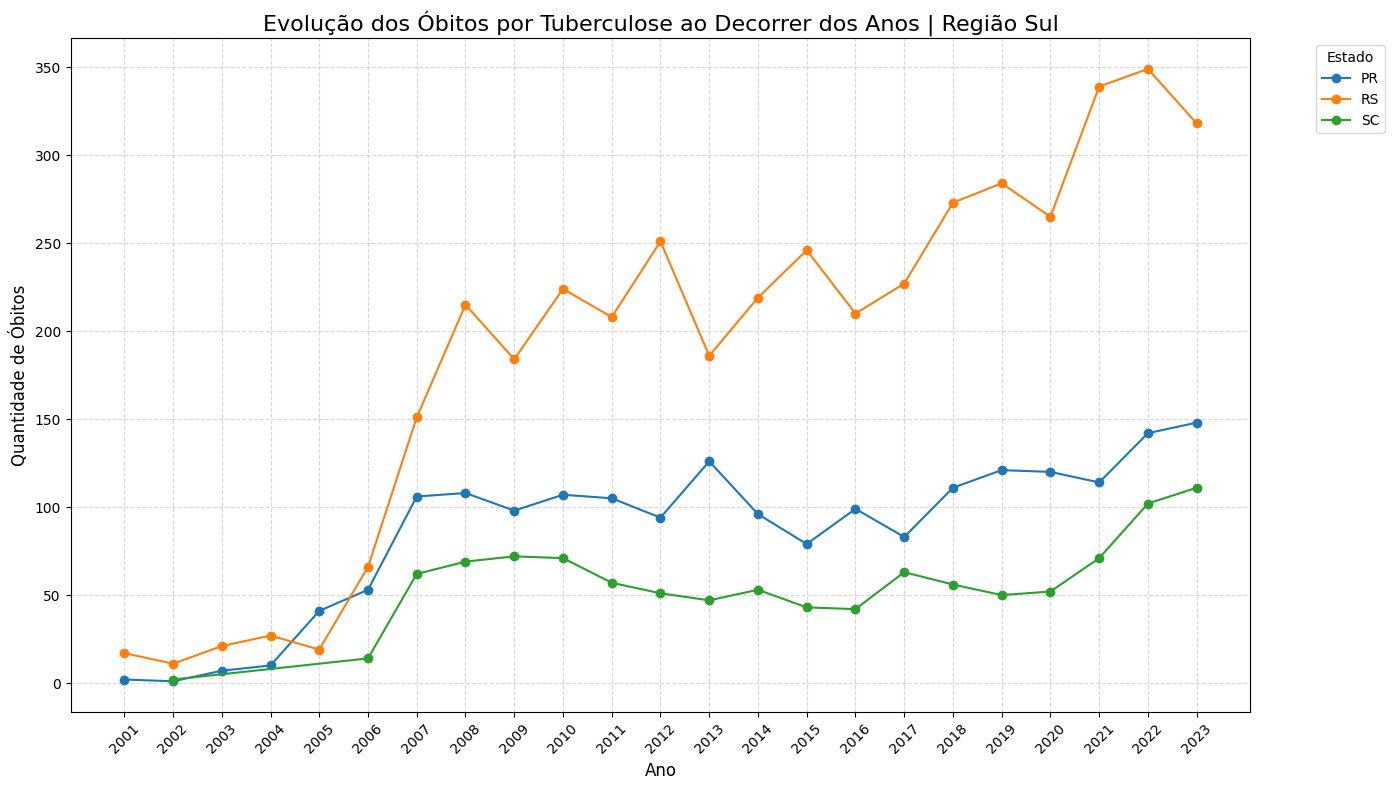

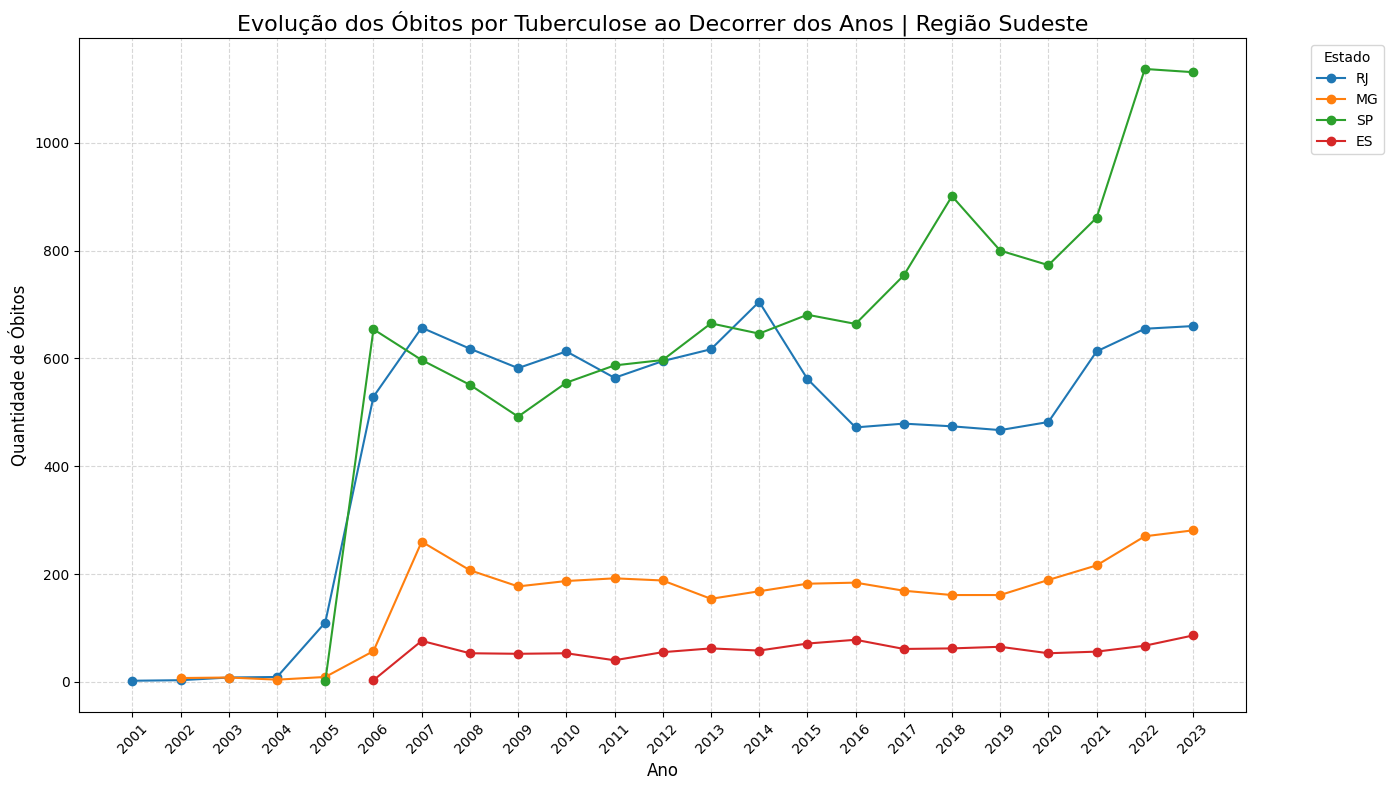

In [ ]:
# Filtrar os dados para considerar apenas óbitos (TP_SITUACAO_ENCERRAMENTO == 3)
df_obitos = df_dados[df_dados['SITUA_ENCE'] == 3]
df_obitos = df_obitos[(df_obitos['NU_ANO'] >= 2001) & (df_obitos['NU_ANO'] <= 2023)]

# Criar DataFrame de estados
df_estados = pd.DataFrame(dados_est)

# Adicionar ao DataFrame original uma coluna para os nomes dos estados e regiões
df_dados_estado = df_obitos.merge(df_estados[['id', 'sigla', 'regiao']], left_on='SG_UF_NOT', right_on='id', how='left')

# Agrupar por ano, estado e região para óbitos
dados_agrupados_obitos = df_dados_estado.groupby(['NU_ANO', 'sigla', 'regiao']).size().reset_index(name='quantidade_obitos')

# Obter lista única de regiões
regioes = dados_agrupados_obitos['regiao'].unique()

# Criar gráficos de linha para cada região
for regiao in regioes:
    fig, ax = plt.subplots(figsize=(14, 8))

    dados_regiao = dados_agrupados_obitos[dados_agrupados_obitos['regiao'] == regiao]

    for estado in dados_regiao['sigla'].unique():
        dados_estado = dados_regiao[dados_regiao['sigla'] == estado]
        ax.plot(
            dados_estado['NU_ANO'],
            dados_estado['quantidade_obitos'],
            marker='o',
            label=estado
        )

    # Configurar títulos e rótulos
    ax.set_title(f'Annual evolution of the number of deaths from Tuberculosis | Region {regioes_brasil[regiao]}', fontsize=16)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Death numbers', fontsize=12)

    # Melhorar a visualização
    plt.xticks(dados_agrupados_obitos['NU_ANO'].unique(), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()

    # Exibir o gráfico para a região atual
    plt.show()

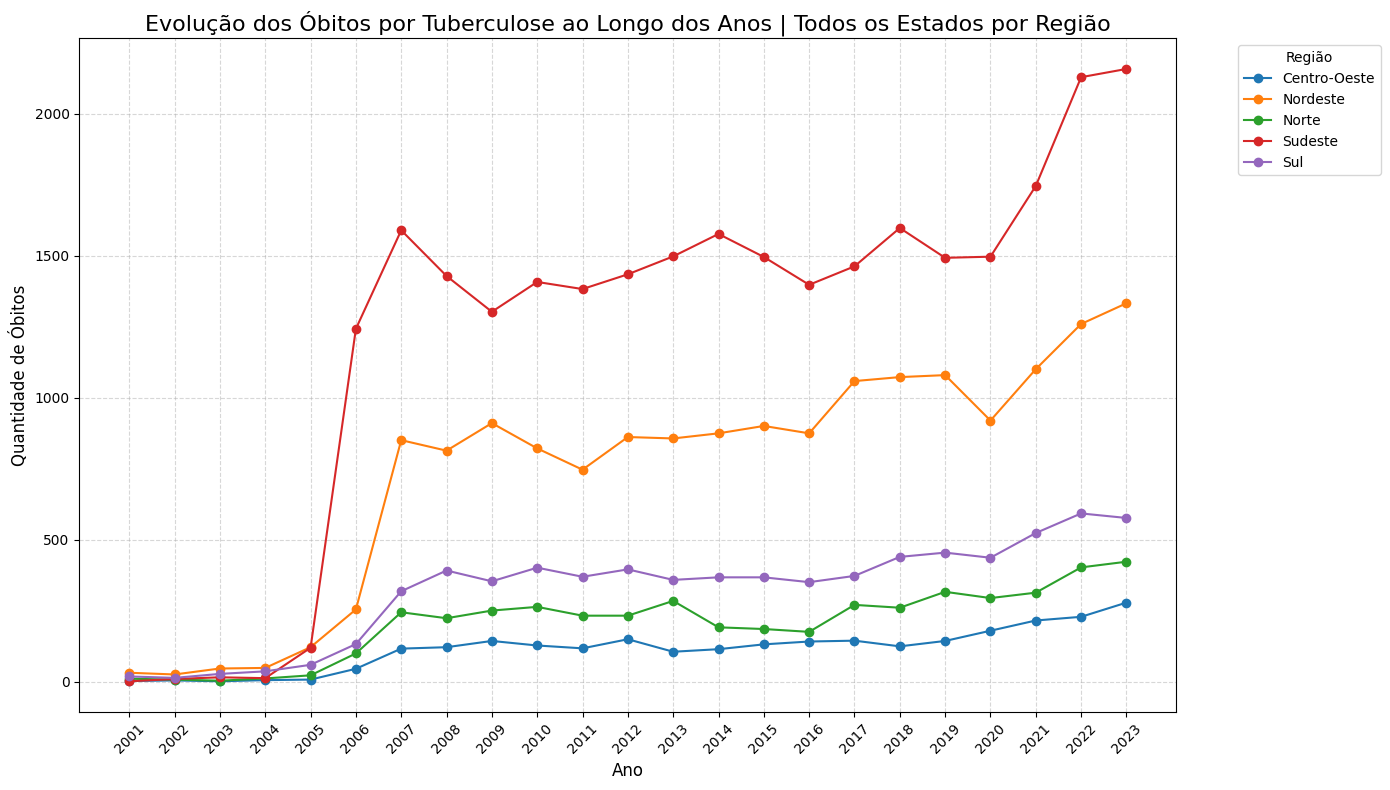

In [ ]:
# Filtrar os dados para considerar apenas óbitos (TP_SITUACAO_ENCERRAMENTO == 3)
df_obitos = df_dados[df_dados['SITUA_ENCE'] == 3]
df_obitos = df_obitos[(df_obitos['NU_ANO'] >= 2001) & (df_obitos['NU_ANO'] <= 2023)]

# Criar DataFrame de estados
df_estados = pd.DataFrame(dados_est)

# Adicionar ao DataFrame original uma coluna para os nomes dos estados e regiões
df_dados_estado = df_obitos.merge(df_estados[['id', 'sigla', 'regiao']], left_on='SG_UF_NOT', right_on='id', how='left')

# Agrupar por ano e região para óbitos
dados_agrupados_obitos = df_dados_estado.groupby(['NU_ANO', 'regiao']).size().reset_index(name='quantidade_obitos')

# Obter lista única de regiões
regioes = dados_agrupados_obitos['regiao'].unique()

# Criar gráfico de linha para cada região, com a soma dos óbitos por ano
fig, ax = plt.subplots(figsize=(14, 8))

# Para cada região, plotar os dados de óbitos
for regiao in regioes:
    dados_regiao = dados_agrupados_obitos[dados_agrupados_obitos['regiao'] == regiao]
    ax.plot(
        dados_regiao['NU_ANO'],
        dados_regiao['quantidade_obitos'],
        marker='o',
        label=regiao
    )

# Configurar título e rótulos
ax.set_title('Evolution of Deaths from Tuberculosis Over the Years | All States by Region', fontsize=16)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of deaths", fontsize=12)

# Melhorar a visualização
plt.xticks(dados_agrupados_obitos['NU_ANO'].unique(), rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
ax.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico para as regiões
plt.show()


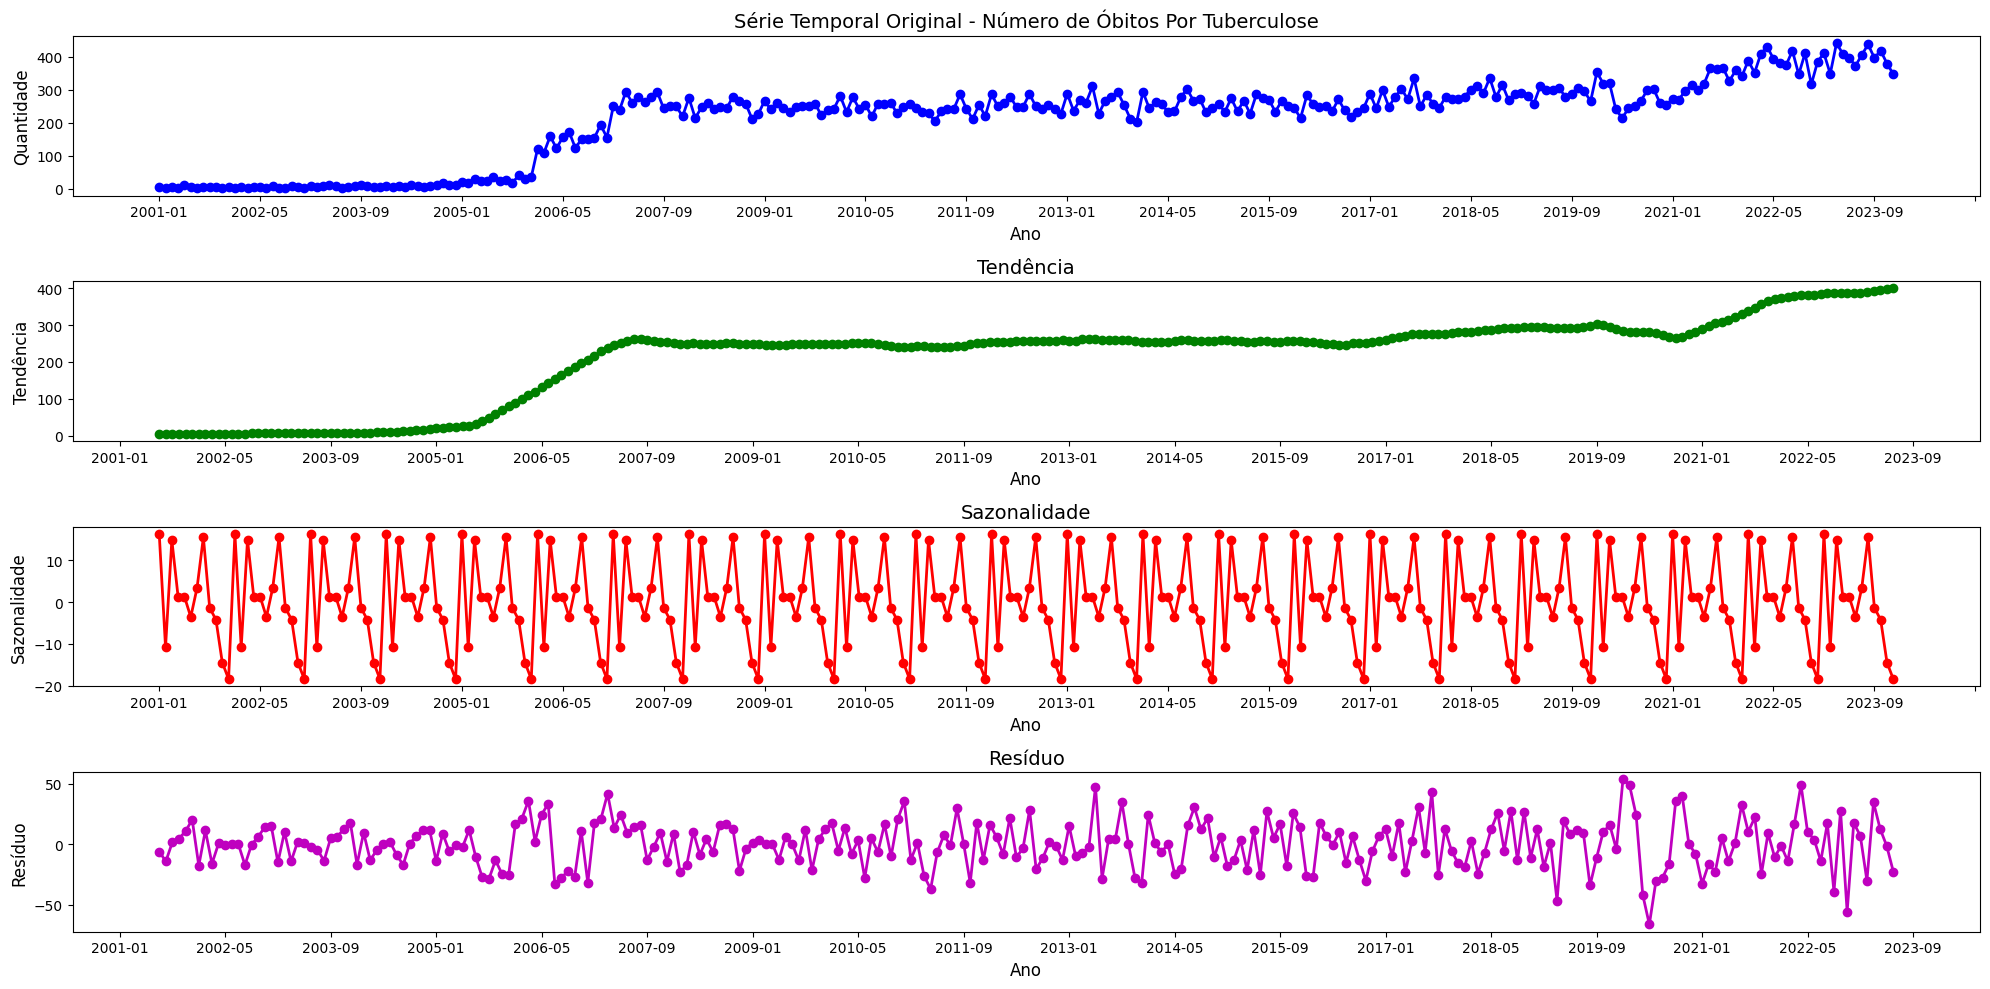

In [ ]:
from matplotlib.ticker import MultipleLocator

df_obitos = df_dados[df_dados['SITUA_ENCE'] == 3].copy()
df_obitos = df_obitos[(df_obitos['NU_ANO'] >= 2001) & (df_obitos['NU_ANO'] <= 2023)]
df_obitos.loc[:, "DT_NOTIFIC"] = pd.to_datetime(df_obitos["DT_NOTIFIC"], format='%Y%m%d', errors='coerce')
df_obitos.loc[:, "ANO_MES"] = df_obitos["DT_NOTIFIC"].dt.to_period("M").astype(str)
dados_agrupados_obitos = df_obitos.groupby("ANO_MES").size().reset_index(name="quantidade_obitos")


decompose = seasonal_decompose(dados_agrupados_obitos["quantidade_obitos"], model="additive", period=12)
tendencia = decompose.trend
sazonalidade = decompose.seasonal
residuo = decompose.resid

# Gerar o gráfico
fig, axes = plt.subplots(4, 1, figsize=(20, 10))

# Plotando a série temporal original
axes[0].plot(dados_agrupados_obitos["ANO_MES"], dados_agrupados_obitos["quantidade_obitos"], marker='o', linestyle='-', linewidth=2, color='b')
axes[0].set_title("Original Time Series - Number of Deaths Due to Tuberculosis", fontsize=14)
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Number of deaths", fontsize=12)
axes[0].xaxis.set_major_locator(MultipleLocator(16))

# Plotando a tendência
axes[1].plot(dados_agrupados_obitos["ANO_MES"], tendencia, marker='o', linestyle='-', linewidth=2, color='g')
axes[1].set_title("Trend", fontsize=14)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Trend", fontsize=12)
axes[1].xaxis.set_major_locator(MultipleLocator(2))
axes[1].xaxis.set_major_locator(MultipleLocator(16))

# Plotando a sazonalidade
axes[2].plot(dados_agrupados_obitos["ANO_MES"], sazonalidade, marker='o', linestyle='-', linewidth=2, color='r')
axes[2].set_title("Seasonality", fontsize=14)
axes[2].set_xlabel("Year", fontsize=12)
axes[2].set_ylabel("Seasonality", fontsize=12)
axes[2].xaxis.set_major_locator(MultipleLocator(2))
axes[2].xaxis.set_major_locator(MultipleLocator(16))

# Plotando o resíduo
axes[3].plot(dados_agrupados_obitos["ANO_MES"], residuo, marker='o', linestyle='-', linewidth=2, color='m')
axes[3].set_title("Residue", fontsize=14)
axes[3].set_xlabel("Year", fontsize=12)
axes[3].set_ylabel("Residue", fontsize=12)
axes[3].set_axis_on()
axes[3].xaxis.set_major_locator(MultipleLocator(2))
axes[3].xaxis.set_major_locator(MultipleLocator(16))
plt.tight_layout()

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Filtrar os dados para considerar apenas óbitos ('SITUA_ENCE' == 3)
df_obitos = df_dados[df_dados['SITUA_ENCE'] == 3].copy()
df_obitos = df_obitos[(df_obitos['NU_ANO'] >= 2001) & (df_obitos['NU_ANO'] <= 2023)]

# Converter a coluna DT_NOTIFIC para datetime
df_obitos.loc[:, "DT_NOTIFIC"] = pd.to_datetime(df_obitos["DT_NOTIFIC"], format='%Y%m%d', errors='coerce')

# Criar uma nova coluna no formato "AAAA-MM"
df_obitos.loc[:, "ANO_MES"] = df_obitos["DT_NOTIFIC"].dt.to_period("M").astype(str)

# Agrupar os dados por "ANO_MES" e contar a quantidade de óbitos
dados_agrupados_obitos = df_obitos.groupby("ANO_MES").size().reset_index(name="quantidade_obitos")

# Preparação dos Dados
dados_agrupados_obitos["ANO_MES"] = pd.to_datetime(dados_agrupados_obitos["ANO_MES"], format='%Y-%m')
dados_agrupados_obitos["ANO_MES_NUM"] = dados_agrupados_obitos["ANO_MES"].map(lambda x: x.toordinal())

# Filtro para ignorar dados antes de 2000
dados_filtrados = dados_agrupados_obitos[dados_agrupados_obitos["ANO_MES"] >= pd.to_datetime("2000-01")]

# Definição das variáveis independentes e dependentes
X = dados_filtrados[["ANO_MES_NUM"]].values
y = dados_filtrados["quantidade_obitos"].values

# Escalonamento dos dados
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Separar dados de treino e teste
limite_pandemia = pd.to_datetime("2020-03").toordinal()
X_treino = X_scaled[X[:, 0] < limite_pandemia]
y_treino = y_scaled[X[:, 0] < limite_pandemia]
X_teste = X_scaled[X[:, 0] >= limite_pandemia]
y_teste = y_scaled[X[:, 0] >= limite_pandemia]

# Função para reverter escalonamento
def inverter_escalonamento(y_pred_scaled):
    return scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))


In [ ]:
print( "dados de treinamento:",len(X_treino))
print("daods do teste:",len(X_teste))
print ("daods totais do dataframe",len (dados_agrupados_obitos))


dados de treinamento: 230
daods do teste: 46
daods totais do dataframe 276


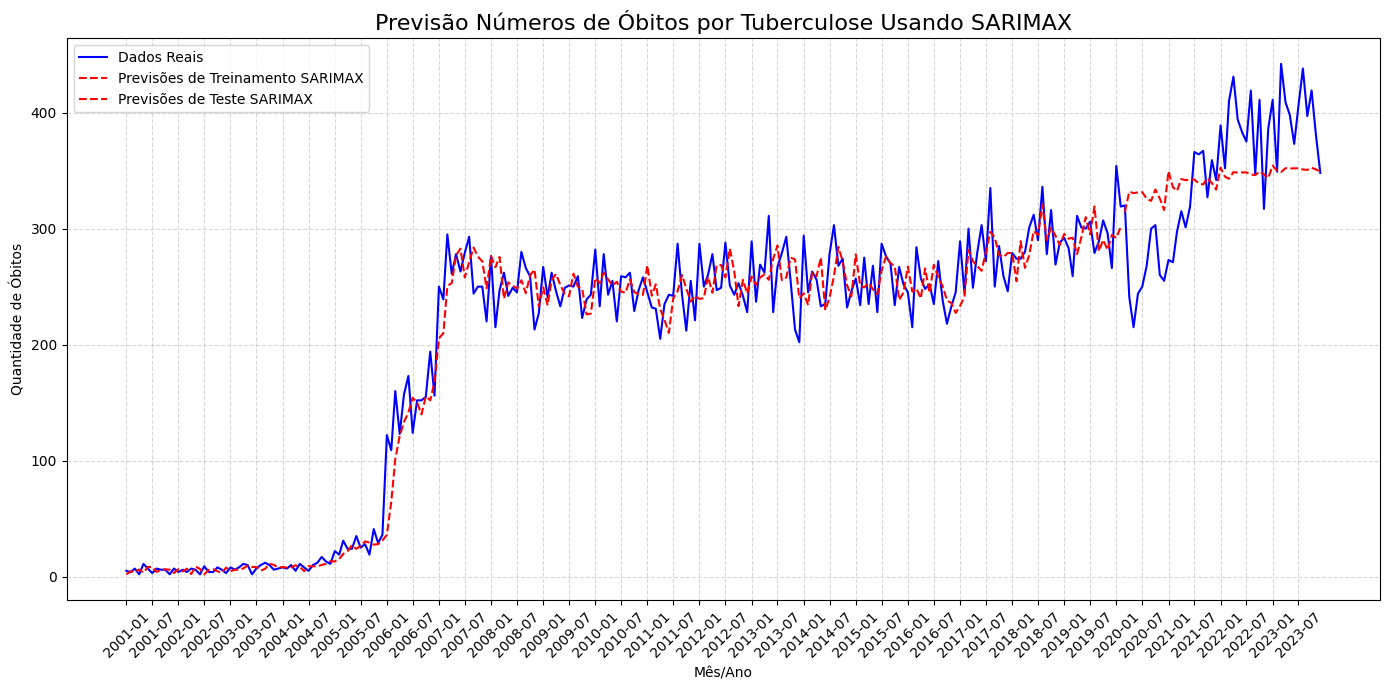

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Treinando o modelo SARIMAX
modelo_sarima = SARIMAX(y_treino, order=(2, 1, 1), seasonal_order=(1, 0, 1, 12),
                        enforce_stationarity=False, enforce_invertibility=False)

modelo_sarima_fit = modelo_sarima.fit(disp=False)

# Fazendo previsões
train_pred_arima = modelo_sarima_fit.predict(start=0, end=len(y_treino)-1)
forecast_arima = modelo_sarima_fit.forecast(steps=(len(dados_filtrados) - len(y_treino)))

# Cálculo das métricas de desempenho para o conjunto de treinamento
mae_train_sx = mean_absolute_error(y_treino, train_pred_sarimax)
mse_train_sx = mean_squared_error(y_treino, train_pred_sarimax)
rmse_train_sx = np.sqrt(mse_train_sx)

# Revertendo o escalonamento das previsões
train_pred_arima_inverted = inverter_escalonamento(train_pred_arima)
forecast_arima_inverted = inverter_escalonamento(forecast_arima)
all_previsions = np.concatenate((train_pred_arima_inverted, forecast_arima_inverted))
mae_test_sx = mean_absolute_error(y, all_previsions)
mse_test_sx = mean_squared_error(y, all_previsions)
rmse_test_sx = np.sqrt(mse_test_sx)

# Criando a linha do tempo para previsões
datas_treino = dados_filtrados["ANO_MES"][:len(train_pred_arima_inverted)]
datas_teste = pd.date_range(start=datas_treino.iloc[-1], periods=len(forecast_arima_inverted) + 1, freq="MS")[1:]

plt.figure(figsize=(14, 7))

# Ajustando o gráfico de previsões
plt.plot(dados_filtrados["ANO_MES"], dados_filtrados["quantidade_obitos"], label="Real data", color="blue")

# Previsões de treinamento
plt.plot(datas_treino, train_pred_arima_inverted,color="red", linestyle="--")

# Previsões de teste
plt.plot(datas_teste, forecast_arima_inverted, label="SARIMAX Predictions", color="red", linestyle="--")

# Ajustando o título e os rótulos
plt.title("Predicting the Number of Deaths from Tuberculosis Using SARIMAX", fontsize=16)
plt.xlabel("Month/Year")
plt.ylabel("Number of Deaths")

# Ajustando as ticks do eixo X para mostrar de 6 em 6 meses dentro do intervalo
xticks = pd.date_range(start=dados_filtrados["ANO_MES"].min(), end=dados_filtrados["ANO_MES"].max(), freq="6MS")
plt.xticks(xticks, labels=[tick.strftime('%Y-%m') for tick in xticks], rotation=45)

# Exibindo legenda e grade
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Exibindo o gráfico
plt.show()


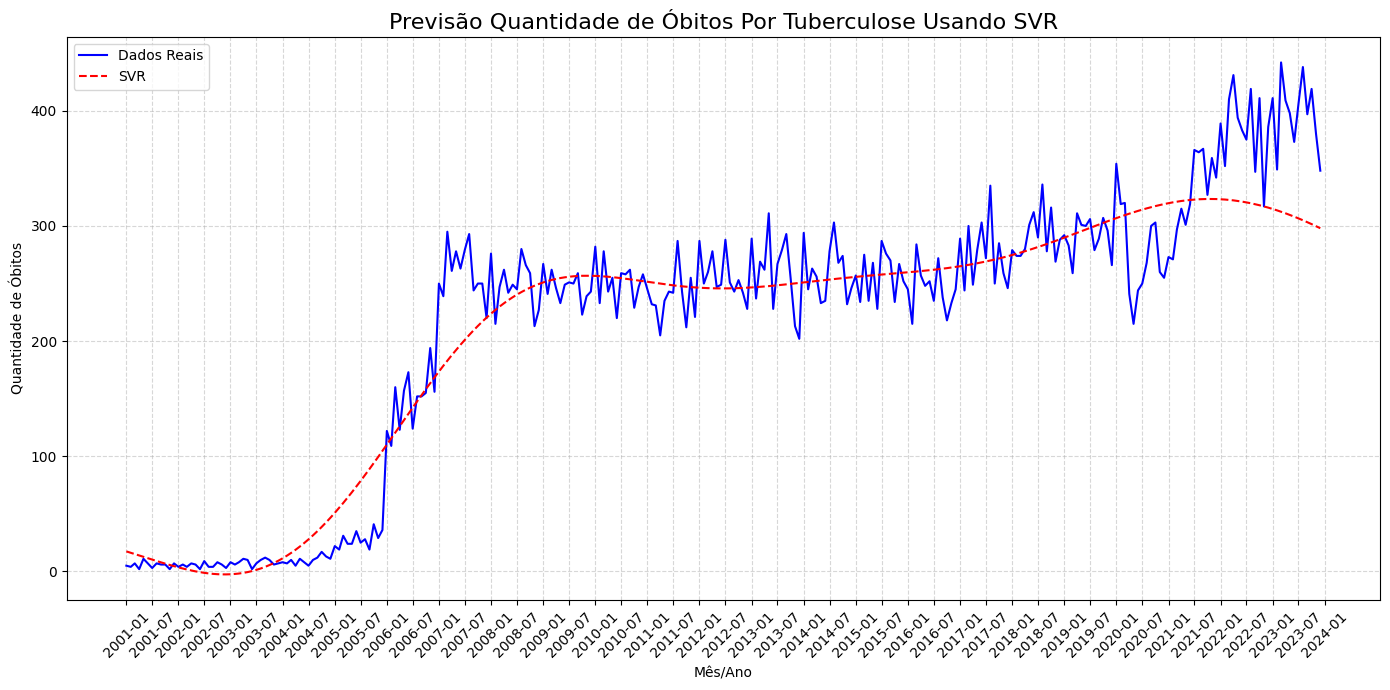

In [ ]:
#Treinando com Suporte a Vetores de Regressão (SVR)
modelo_svr = SVR(kernel='rbf', C=0.7, epsilon=0.01)
modelo_svr.fit(X_treino, y_treino.ravel())

# Fazendo previsões no conjunto de treinamento
train_pred_svr_scaled = modelo_svr.predict(X_treino)
train_pred_svr = inverter_escalonamento(train_pred_svr_scaled)

#Avalia o desempenho durante o treinamento
mae_train_SVR = mean_absolute_error(y_treino, train_pred_svr_scaled)
mse_train_SVR = mean_squared_error(y_treino, train_pred_svr_scaled)
rmse_train_SVR = np.sqrt(mse_train_SVR)

dados_filtrados = dados_agrupados_obitos[dados_agrupados_obitos["ANO_MES"] >= pd.to_datetime("2000-01")]
dados_filtrados["ANO_MES_NUM"] = dados_filtrados["ANO_MES"].map(lambda x: x.toordinal())
X_scaled_filtered = scaler_X.transform(dados_filtrados[["ANO_MES_NUM"]].values)
y_pred_svr_scaled = modelo_svr.predict(X_scaled_filtered)
y_pred_svr = inverter_escalonamento(y_pred_svr_scaled)

#Avalia o desempenho alcançado durante o teste.
mae_test_SVR = mean_absolute_error(y, y_pred_svr)
mse_test_SVR = mean_squared_error(y, y_pred_svr)
rmse_test_SVR = np.sqrt(mse_test_SVR)

plt.figure(figsize=(14, 7))

# Ensure both x and y have the same length for plotting
plt.plot(dados_filtrados["ANO_MES"], dados_filtrados["quantidade_obitos"], label="Real data", color="blue")
plt.plot(dados_filtrados["ANO_MES"], y_pred_svr, label=f"SVR", color="red", linestyle="--")

plt.title(f"Predicting Number of Deaths Due to Tuberculosis Using SVR", fontsize=16)
plt.xlabel("Month/Year")
plt.ylabel("Number of Deaths")
xticks = pd.date_range(dados_agrupados["ANO_MES"].min(), dados_agrupados["ANO_MES"].max(), freq="6MS")
xticks = xticks.append(pd.DatetimeIndex([pd.Timestamp("2024-01")]))
plt.xticks(xticks, labels=[tick.strftime('%Y-%m') for tick in xticks], rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

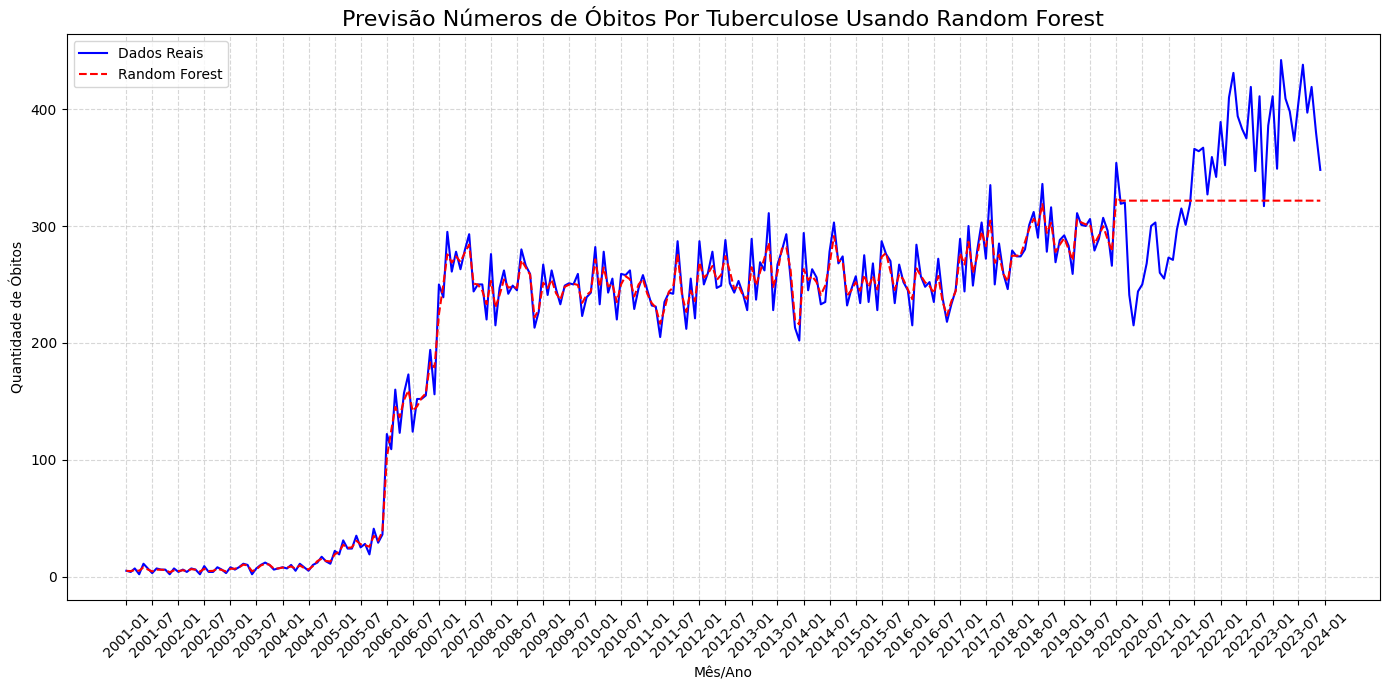

In [ ]:
# Previsão usando Random Forest

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_treino, y_treino.ravel())
y_pred_rf = inverter_escalonamento(modelo_rf.predict(X_scaled))

# Previsões no conjunto de treinamento
train_pred_rf_scaled = modelo_rf.predict(X_treino)
train_pred_rf = inverter_escalonamento(train_pred_rf_scaled)

# Cálculo das métricas de desempenho para o conjunto de treinamento
mae_train_rf = mean_absolute_error(y_treino, train_pred_rf_scaled)
mse_train_rf = mean_squared_error(y_treino, train_pred_rf_scaled)
rmse_train_rf = np.sqrt(mse_train_rf)

# Cálculo das métricas de desempenho para o conjunto de teste
y_test = dados_filtrados["quantidade_obitos"].values
mae_test_rf = mean_absolute_error(y_test, y_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_rf)
rmse_test_rf = np.sqrt(mse_test_rf)

plt.figure(figsize=(14, 7))

# Ensure both x and y have the same length for plotting
plt.plot(dados_filtrados["ANO_MES"], dados_filtrados["quantidade_obitos"], label="Dados Reais", color="blue")
plt.plot(dados_filtrados["ANO_MES"], y_pred_rf, label=f"Random Forest", color="red", linestyle="--")

plt.title(f"Predicting Numbers of Deaths From Tuberculosis Using Random Forest", fontsize=16)
plt.xlabel("Month/Year")
plt.ylabel("Number of Deaths")
xticks = pd.date_range(dados_agrupados["ANO_MES"].min(), dados_agrupados["ANO_MES"].max(), freq="6MS")
xticks = xticks.append(pd.DatetimeIndex([pd.Timestamp("2024-01")]))
plt.xticks(xticks, labels=[tick.strftime('%Y-%m') for tick in xticks], rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

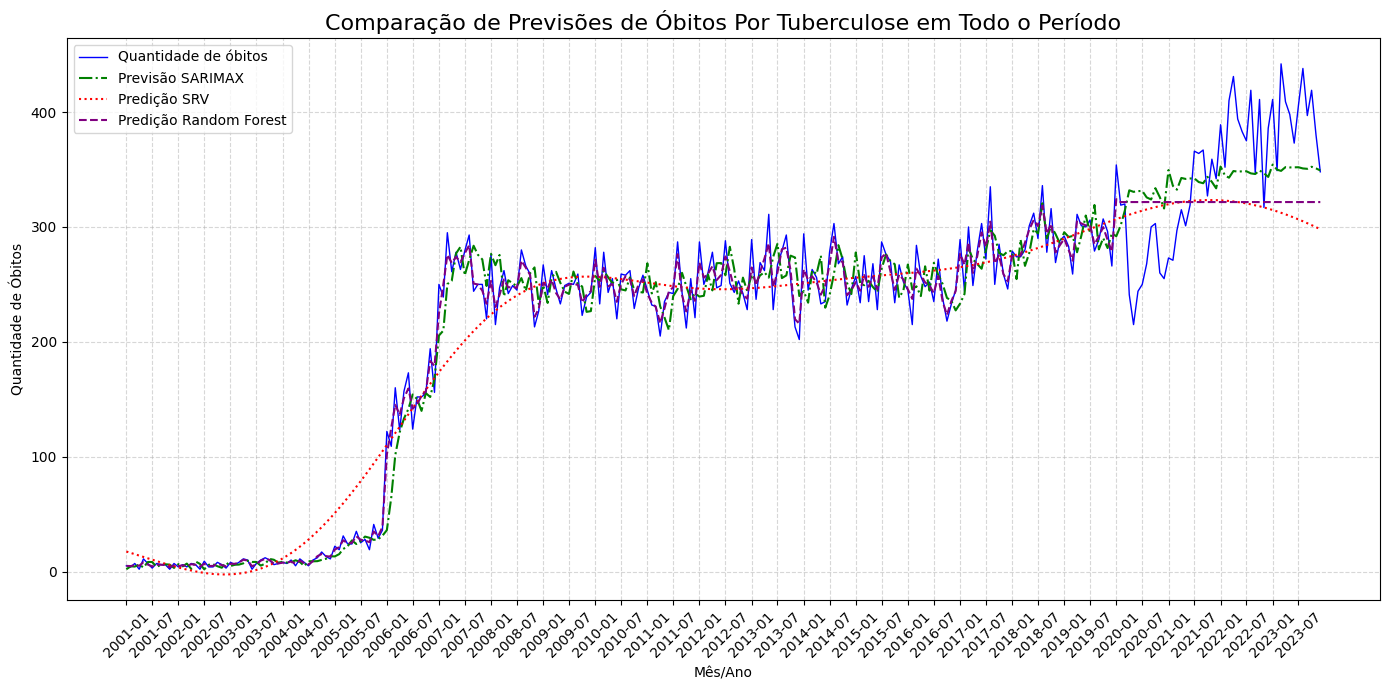

In [ ]:
# Plotar os resultados (todo o período)
plt.figure(figsize=(14, 7))

# Dados reais
plt.plot(dados_filtrados["ANO_MES"],y, label="Quantidade de óbitos", color="blue", linewidth=1)

# Previsões
#plt.plot(dados_agrupados["ANO_MES"], result_Arima, label="Previsão ARIMA", color="red", linestyle="--")
plt.plot(dados_filtrados["ANO_MES"], all_previsions, label="SARIMAX Forecast", color="green", linestyle="-.")
plt.plot(dados_filtrados["ANO_MES"], y_pred_svr, label="SRV Forecast", color="red", linestyle=":")
plt.plot(dados_filtrados["ANO_MES"], y_pred_rf , label="Random Forest Forecast", color="purple", linestyle="--")

# Adicionar informações ao gráfico
plt.title("Comparison of Forecasts of Deaths Due to Tuberculosis Over the Entire Period", fontsize=16)
plt.xlabel("Month/Year")
plt.ylabel("Number of Deaths")
xticks = pd.date_range(dados_agrupados["ANO_MES"].min(), dados_agrupados["ANO_MES"].max(), freq="6MS")
plt.xticks(xticks, labels=[tick.strftime('%Y-%m') for tick in xticks], rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#Exibe os resultados obtidos para as métricas de desempenho:
print("----------------------------------")
print("Métricas de desempenho durante o treinamento:")
print("----------------------------------")
print(f"MAE SARIMAX:",mae_train_sx )
print(f"MAE SRV:", mae_train_SVR )
print(f"MAE Random Forest:",mae_train_rf)
print("----------------------------------")
print(f"MSE SARIMAX:",mse_train_sx )
print(f"MSE SRV:", mse_train_SVR )
print(f"MSE Random Forest:",mse_train_rf)
print("----------------------------------")
print(f"RMSE SARIMAX:", rmse_train_sx)
print(f"RMSE SRV:", rmse_train_SVR )
print(f"RMSE Random Forest:",rmse_train_rf)
print("\n")
print("----------------------------------")
print("Métricas de desempenho para todo o período:")
print("----------------------------------")
print(f"MAE SARIMAX:",mae_test_sx )
print(f"MAE SRV:", mae_test_SVR )
print(f"MAE Random Forest:",mae_test_rf)
print("----------------------------------")
print(f"MSE SARIMAX:",mse_test_sx )
print(f"MSE SRV:", mse_test_SVR )
print(f"MSE Random Forest:",mse_test_rf)
print("----------------------------------")
print(f"RMSE SARIMAX:", rmse_test_sx)
print(f"RMSE SRV:", rmse_test_SVR )
print(f"RMSE Random Forest:",rmse_test_rf)

----------------------------------
Métricas de desempenho durante o treinamento:
----------------------------------
MAE SARIMAX: 0.2862911800849745
MAE SRV: 0.04641353499621188
MAE Random Forest: 0.015504249011857674
----------------------------------
MSE SARIMAX: 0.09399254177214382
MSE SRV: 0.0040533966222127795
MSE Random Forest: 0.0004666528184513113
----------------------------------
RMSE SARIMAX: 0.10751991589716935
RMSE SRV: 0.06366629109829455
RMSE Random Forest: 0.021602148468411915


----------------------------------
Métricas de desempenho para todo o período:
----------------------------------
MAE SARIMAX: 29.9347163227374
MAE SRV: 33.72512485185713
MAE Random Forest: 23.194753521126753
----------------------------------
MSE SARIMAX: 4050.1522443873714
MSE SRV: 3484.4101573248095
MSE Random Forest: 3372.9432616197146
----------------------------------
RMSE SARIMAX: 63.640806440422885
RMSE SRV: 59.028892563936935
RMSE Random Forest: 58.0770459098921
